# **PORTFOLIO OPTIMISATION 2021**

In [1]:
import numpy as np
import pandas as pd
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import investpy as ipy
%matplotlib inline
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from statsmodels import regression
from sklearn.linear_model import LinearRegression
#from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
today = dt.datetime.today().strftime("%d/%m/%Y")
import mlportfolio

In [2]:
#pd.set_option('display.max_rows', 100)
#plt.rcParams['axes.xmargin'] = 0
scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

In [3]:
def log_rate(df):
    return np.log(df / df.shift(1)).dropna(how='all')

def ewcorr(df, span=300):
    corr = df.ewm(span=span).corr()
    return corr.loc[corr.index.levels[0][-1]]

def ewcov(df, span=300):
    cov = df.ewm(span=span).cov()
    return cov.loc[cov.index.levels[0][-1]]

def ewstd(df, span=300):
    std = df.ewm(span=span).std()
    return std.iloc[-1]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontweight='semibold', alpha=0.7)

In [4]:
plt.style.use(['seaborn'])

In [5]:
pd.set_option("display.max_rows", 20)
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Lists of Stocks 

Here, the most up-to-date list of Kompas 100 stocks is collected from Kontan. Kompas 100 was chosen as the stocks universe as it provides a larger dataset than LQ45 or IDX30 yet manageable enough for the computational  resource available for the research in comparison to the 600+ of stocks listed on IDX.

In [6]:
lis = mlportfolio.index_list_kontan('KOMPAS100')
df = lis.download()
df

,No.,Kode,Nama Saham,Keterangan
0,1,AALI,Astra Agro Lestari Tbk.,Tetap
1,2,ACES,Ace Hardware Indonesia Tbk.,Tetap
2,3,ADHI,Adhi Karya (Persero) Tbk.,Baru
3,4,ADRO,Adaro Energy Tbk.,Tetap
4,5,AGII,Aneka Gas Industri Tbk.,Baru
...,...,...,...,...
95,96,WIIM,Wismilak Inti Makmur Tbk.,Tetap
96,97,WIKA,Wijaya Karya (Persero) Tbk.,Tetap
97,98,WOOD,Integra Indocabinet Tbk.,Tetap
98,99,WSKT,Waskita Karya (Persero) Tbk.,Tetap


In [7]:
code = df['Kode']
code_arr =[]
sym = []
for i in range(len(code)):
  sym.append(code[i])
  code_arr.append(code[i]+'.JK')

## **Data Reader**

After the list of stocks has been collected, using `yfinance` module to download the historical time series data from Yahoo Finance. The data collected for these stocks span from 1 Jan 2010 to today.

### **KOMPAS100 Stocks Prices: 2010-2021**

In [8]:
training_year ='2019'
test_year = '2020'
end_year = '2021'

In [9]:
# df1 = yf.download(code_arr, start='2010-01-01')
# df1.info()

In [10]:
# df1.to_pickle('stocks-data.pkl')

In [11]:
df = pd.read_pickle('stocks-data.pkl')

In [12]:
df=df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2010-01-04 to 2021-12-13
Columns: 600 entries, ('Adj Close', 'AALI.JK') to ('Volume', 'WTON.JK')
dtypes: float64(600)
memory usage: 13.5 MB


In [13]:
data_count = df['Adj Close'].describe().loc['count']

In [14]:
thresh=data_count.median()

<AxesSubplot:>

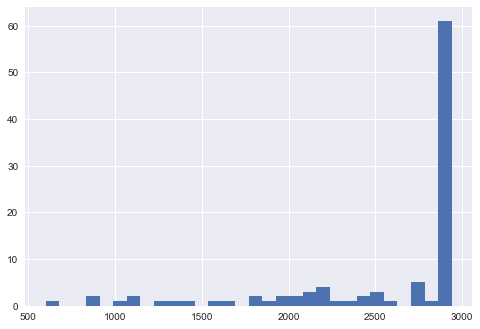

In [15]:
data_count.hist(bins=30)

In [16]:
df1 = df.dropna(axis=1, thresh=thresh)

<AxesSubplot:xlabel='Date', ylabel='Adj Close Price'>

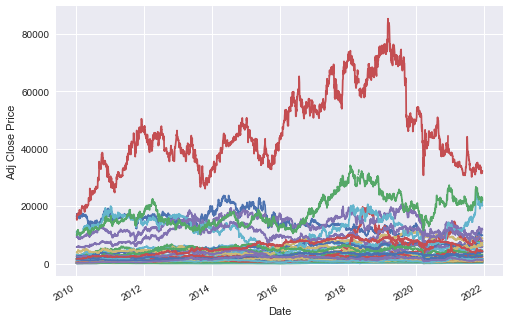

In [17]:
df1['Adj Close'].plot(legend=False, xlabel='Date', ylabel='Adj Close Price' )

In [18]:
adj_close = df1['Adj Close']

In [19]:
columns=df1.columns.get_level_values(0).unique()

In [20]:
df1.groupby(level=0, axis=1).mean().describe().round(2)

,Adj Close,Close,High,Low,Open,Volume
count,2945.00,2945.00,2945.00,2945.00,2945.00,2.945000e+03
mean,4051.23,4929.55,5001.18,4859.64,4932.98,3.067864e+07
std,759.20,685.55,687.48,682.76,685.68,1.565195e+07
min,1312.52,1335.00,1335.00,1335.00,1335.00,0.000000e+00
25%,3546.16,4500.06,4580.42,4431.99,4502.73,2.195886e+07
50%,4009.96,4977.58,5052.96,4913.75,4983.60,2.730578e+07
75%,4496.56,5359.39,5420.95,5282.19,5355.99,3.493761e+07
max,6117.38,6838.59,6838.59,6838.59,6838.59,1.878984e+08


In [21]:
df1.groupby(level=0, axis=1).mean().round(2)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,2219.25,3394.89,3427.35,3313.44,3359.85,17055766.65
2010-01-05,2248.67,3448.27,3473.45,3385.44,3446.54,29412161.88
2010-01-06,2245.34,3441.43,3507.69,3405.32,3438.84,31741730.48
2010-01-07,2248.64,3441.88,3499.48,3386.57,3439.67,33546109.37
2010-01-08,2284.49,3492.09,3518.48,3427.29,3492.33,23862044.17
...,...,...,...,...,...,...
2021-12-07,4366.52,4366.52,4410.96,4317.00,4360.44,29842071.15
2021-12-08,4325.35,4325.35,4408.77,4306.40,4374.88,29492005.77
2021-12-09,4340.31,4340.31,4386.10,4301.19,4339.77,24417751.92


In [22]:
adj_close

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16410.125000,270.381287,1063.347290,754.387878,1601.085449,2518.653564,96.725533,855.341125,588.306885,655.905151,...,1855.615967,116.141266,448.737213,5704.010254,259.101562,1120.500000,1403.605713,9867.144531,1649.384644,247.194794
2010-01-05,16650.947266,263.786591,1087.652222,742.020874,1601.085449,2532.923584,98.567917,863.809998,592.078125,655.905151,...,1855.615967,118.374763,482.732574,5779.062988,263.647217,1146.864624,1410.954590,10118.534180,1701.627808,247.194794
2010-01-06,16582.144531,267.083893,1093.728638,735.837280,1601.085449,2518.653564,98.567917,838.403809,584.535706,726.180725,...,1897.314941,111.674309,469.134491,5854.115723,268.192841,1160.047241,1396.257080,10087.111328,1686.700806,247.194794
2010-01-07,17235.794922,270.381287,1118.033569,723.470398,1635.891724,2440.168457,99.489105,842.638184,576.993347,726.180725,...,1902.527344,110.557556,455.536346,5779.062988,268.192841,1146.864624,1359.513550,9961.415039,1656.848022,247.194794
2010-01-08,17373.404297,273.678589,1190.949097,717.286987,1635.891724,2454.438232,102.252693,821.466431,580.764526,749.605896,...,1907.739746,111.674309,448.737213,5741.537109,268.192841,1146.864624,1374.210938,10307.079102,1664.311157,243.449371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07,9925.000000,1090.000000,1905.000000,4260.000000,2340.000000,5925.000000,171.000000,7350.000000,4230.000000,1750.000000,...,2750.000000,486.000000,695.000000,8075.000000,880.000000,1550.000000,4150.000000,23000.000000,4270.000000,1215.000000
2021-12-08,9925.000000,1085.000000,1925.000000,4290.000000,2330.000000,5800.000000,171.000000,7425.000000,4210.000000,1750.000000,...,2720.000000,488.000000,695.000000,8025.000000,875.000000,1540.000000,4090.000000,22350.000000,4270.000000,1205.000000
2021-12-09,9950.000000,1075.000000,1935.000000,4330.000000,2330.000000,6000.000000,172.000000,7350.000000,4190.000000,1750.000000,...,2720.000000,480.000000,690.000000,8025.000000,880.000000,1565.000000,4150.000000,22325.000000,4370.000000,1190.000000


In [23]:
pd.DataFrame(adj_close.columns)

,0
0,AALI.JK
1,ADHI.JK
2,ADRO.JK
3,AKRA.JK
4,ANTM.JK
...,...
47,TINS.JK
48,TLKM.JK
49,UNTR.JK
50,UNVR.JK


### **KOMPAS 100 Index Prices: 2010-2021**

In [24]:
# df2 = ipy.indices.get_index_historical_data(index='idx kompas 100', country='Indonesia', from_date='01/01/2010', to_date= today)
# df2.info()

In [25]:
# df2.to_pickle('market-data.pkl')

In [26]:
df2 = pd.read_pickle('market-data.pkl')
df2.describe().round(2)

,Open,High,Low,Close,Volume
count,2926.00,2926.00,2926.00,2926.00,2.926000e+03
mean,1052.30,1058.85,1044.65,1051.93,3.858968e+09
std,172.92,172.46,172.77,172.28,3.313029e+10
min,591.86,595.92,580.38,592.09,0.000000e+00
25%,922.67,929.16,914.17,923.21,2.256659e+09
50%,1069.06,1075.26,1061.62,1068.62,2.897808e+09
75%,1193.59,1200.60,1187.73,1193.44,3.788222e+09
max,1420.94,1421.95,1406.81,1421.50,1.793415e+12


In [27]:
df2.head(10)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-01-04,612.33,623.58,612.04,623.31,1528898048,IDR
2010-01-05,623.36,631.41,623.36,631.08,5152591360,IDR
2010-01-06,631.14,635.74,626.50,630.07,4109481984,IDR
2010-01-07,630.13,632.35,621.29,625.70,3900115968,IDR
2010-01-08,625.67,632.41,624.81,632.34,6547479040,IDR
2010-01-11,632.68,641.39,632.68,636.44,4524621824,IDR
2010-01-12,636.47,644.06,634.09,643.83,4894687744,IDR
2010-01-13,643.37,643.37,634.10,636.56,3641117440,IDR
2010-01-14,636.76,644.18,636.76,639.53,4644381184,IDR


<AxesSubplot:xlabel='Date'>

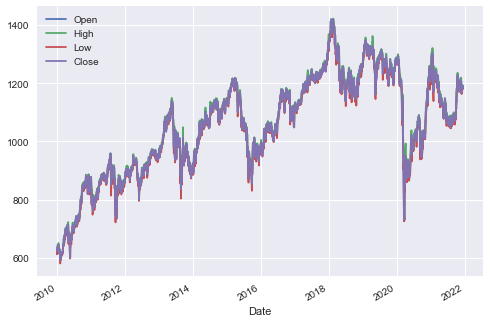

In [28]:
df2.iloc[:, :4].plot()

### **Indonesia Gov't Bond Yield 1 Year: 2010-2021**

Here, the bond yields of Indonesia's 1 Year Bond from 1 Jan 2010 to today are collected from Investing.com. 

In [29]:
# df5 = ipy.bonds.get_bond_historical_data(bond = 'INDONESIA 1Y', from_date='01/01/2010', to_date= today)
# bond_yield = df5[df5.index.isin(df2.index)].divide(100)

In [30]:
# bond_yield.to_pickle('bond-data.pkl')

<AxesSubplot:xlabel='Date', ylabel='Rate'>

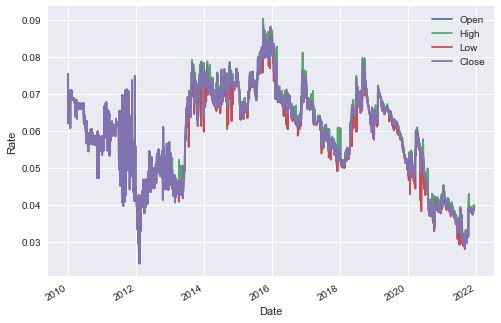

In [31]:
bond_yield = pd.read_pickle('bond-data.pkl').replace(0, method='ffill')
bond_yield.plot(ylabel='Rate')

In [32]:
bond_yield.describe().round(3)

,Open,High,Low,Close
count,2909.000,2909.000,2909.000,2909.000
mean,0.059,0.060,0.059,0.059
std,0.013,0.013,0.012,0.013
min,0.024,0.024,0.024,0.024
25%,0.050,0.051,0.050,0.050
50%,0.062,0.062,0.062,0.062
75%,0.068,0.069,0.068,0.068
max,0.090,0.090,0.089,0.089


### **Financial Summaries of KOMPAS100 Companies**

In [33]:
# info_summ = pd.DataFrame()
# fin_dict = {}

# for x in sym: 
#     info = ipy.stocks.get_stock_information(stock= x, country= 'Indonesia')
#     info_summ = info_summ.append(info)
    
#     try:
#         inc_sta = ipy.stocks.get_stock_financial_summary(stock= x, country= 'Indonesia', summary_type='income_statement')
#         fin_dict[x +'.JK']= inc_sta.sort_values(by='Date')
#     except:
#         pass

In [34]:
# fin_summ = pd.concat(fin_dict, axis=1)*1000000 #Values should be in millions IDR

# info_summ.reset_index(drop=True)
# info_summ.index = code_arr

In [35]:
# fin_summ.to_pickle('fin-summ.pkl')
# info_summ.to_pickle('info-summ.pkl')

In [36]:
info_summ = pd.read_pickle('info-summ.pkl')
info_summ.sample(n=5)

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date
INKP.JK,INKP,7900.0,"7,750-7,950",4.511000e+13,7900.0,"6,200-15,550",973.56,4177400.0,4.322000e+13,50.00(0.63%),8297190.0,8.11,1.91,-3.36%,5.470983e+09,22/11/2021
BDMN.JK,BDMN,2510.0,"2,500-2,590",1.128000e+13,2520.0,"2,030-3,520",118.72,4527700.0,2.473000e+13,36.08(1.43%),7018648.0,21.31,2.16,14.48%,9.773553e+09,27/10/2021
BRPT.JK,BRPT,1010.0,"990-1,015",4.014000e+13,1010.0,"635-1,295",20.95,30321100.0,9.365000e+13,2.72(0.27%),52768521.0,47.98,1.69,34.9%,9.318714e+10,10/11/2021
MIKA.JK,MIKA,2370.0,"2,350-2,410",4.370000e+12,2370.0,"2,200-3,220",82.82,20173000.0,3.418000e+13,36.00(1.52%),29542352.0,28.98,0.44,7.14%,1.424096e+10,02/11/2021
WSKT.JK,WSKT,850.0,845-885,1.287000e+13,885.0,"486-2,080",-459.88,18799300.0,1.161000e+13,N/A(N/A),30048835.0,-,3.11,48.7%,1.357395e+10,03/11/2021


In [37]:
fin_summ = pd.read_pickle('fin-summ.pkl')
fin_test=fin_summ[:training_year]

In [38]:
fin_test

AALI.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  1.730569e+13  4.145250e+12     2.992440e+12  1.968027e+12   
2018-12-31  1.908439e+13  3.539506e+12     2.180324e+12  1.438511e+12   
2019-12-31  1.745274e+13  2.144506e+12     1.028365e+12  2.111170e+11   

                 ACES.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  5.938576e+12  2.799301e+12     9.706619e+11  7.777271e+11   
2018-12-31  7.239754e+12  3.402864e+12     1.229001e+12  9.645540e+11   
2019-12-31  8.142717e+12  3.842647e+12     1.363919e+12  1.017395e+12   

                 ADHI.JK                ...          WOOD.JK                \
           Total Revenue  Gross Profit  ... Operating Income    Net Income   
Date                                    ...                                  
2017-12-31  1.515618e+13  2.057806e+12  ...     3.459184e+11  1.735267e+11   
2018-12-31  1.565550e+13  2.506603e+12  ...     4.701462e+11  2.392664e+11   
2019-12-31  1.530786e+13  2.336054e+12  ...     4.902693e+11  2.178162e+11   

                 WSKT.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  4.521290e+13  9.463532e+12     6.526601e+12  3.881712e+12   
2018-12-31  4.878895e+13  8.862619e+12     7.966902e+12  3.962838e+12   
2019-12-31  3.138739e+13  5.604643e+12     5.239472e+12  9.381424e+11   

                 WTON.JK                                               
           Total Revenue  Gross Profit Operating Income    Net Income  
Date                                                                   
2017-12-31  5.362263e+12  6.666394e+11     5.303587e+11  3.371242e+11  
2018-12-31  6.930628e+12  8.824219e+11     7.325459e+11  4.863531e+11  
2019-12-31  7.083384e+12  9.507170e+11     7.856503e+11  5.123467e+11  

[3 rows x 369 columns]

In [39]:
avg_growth = fin_test.pct_change().dropna().mean().rename(index={'Total Revenue': 'Mean Revenue Growth', 'Gross Profit':'Mean Gross Profit Growth',
                                                                'Net Income': 'Mean Net Income Growth', 'Operating Income': 'Mean Operating Income Growth'})

growth_dict={'Mean Rev. Growth': avg_growth[:,'Mean Revenue Growth'], 'Mean Gross Profit Growth': avg_growth[:,'Mean Gross Profit Growth'],
             'Mean Net Inc. Growth': avg_growth[:,'Mean Net Income Growth'], 'Mean Op. Inc. Growth': avg_growth[:,'Mean Operating Income Growth']}

In [40]:
growth_data = pd.concat(growth_dict, axis=1)
growth_data

,Mean Rev. Growth,Mean Gross Profit Growth,Mean Net Inc. Growth,Mean Op. Inc. Growth
AALI.JK,0.008642,-0.270126,-0.561149,-0.399866
ACES.JK,0.171914,0.172426,0.147502,0.187963
ADHI.JK,0.005370,0.075027,0.140143,-0.072490
ADRO.JK,0.033001,-0.071382,-0.084041,-0.185287
AGII.JK,0.095309,0.089202,0.088969,0.058248
...,...,...,...,...
WIIM.JK,-0.028261,-0.001226,-0.102966,-0.167387
WIKA.JK,0.031848,0.109351,0.380012,0.309106
WOOD.JK,0.113999,0.162222,0.144598,0.200963
WSKT.JK,-0.138788,-0.215553,-0.371183,-0.060832


In [41]:
index_=adj_close.columns
eps = info_summ['EPS'][index_]
per = pd.to_numeric(info_summ['P/E Ratio'], errors='coerce').fillna(0)[index_]
mcap = pd.to_numeric(info_summ['Market Cap'], errors='coerce')[index_]
beta_real = pd.to_numeric(info_summ['Beta'], errors='coerce')[index_]

## **Daily Returns of Stocks**

In [42]:
close_price_all = adj_close.interpolate(method='time', axis=0)#.dropna(axis=0, how='all').round(2)
close_price_all[(close_price_all==0).any(axis=1)]

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,


In [43]:
close_price = close_price_all[:training_year]

In [44]:
ret_all = log_rate(close_price)#close_price.apply(lambda x: np.log(1+x)).pct_change().dropna(how='all')

In [45]:
ret_all

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014569,-0.024693,0.022600,-0.016529,0.000000,0.005650,0.018868,0.009852,0.006390,0.000000,...,0.000000,0.019048,0.073025,0.013072,0.017392,0.023257,0.005222,0.025158,0.031183,0.000000
2010-01-06,-0.004141,0.012422,0.005571,-0.008368,0.000000,-0.005650,0.000000,-0.029853,-0.012821,0.101783,...,0.022223,-0.058269,-0.028573,0.012903,0.017094,0.011429,-0.010471,-0.003110,-0.008811,0.000000
2010-01-07,0.038662,0.012270,0.021979,-0.016949,0.021506,-0.031657,0.009302,0.005038,-0.012987,0.000000,...,0.002743,-0.010050,-0.029414,-0.012903,0.000000,-0.011429,-0.026668,-0.012539,-0.017857,0.000000
2010-01-08,0.007952,0.012121,0.063179,-0.008584,0.000000,0.005831,0.027399,-0.025447,0.006515,0.031749,...,0.002736,0.010050,-0.015038,-0.006515,0.000000,0.000000,0.010753,0.034112,0.004494,-0.015268
2010-01-11,-0.011952,-0.012121,0.010152,0.017094,-0.010695,0.015862,0.052644,0.010256,0.000000,-0.021054,...,-0.010989,0.000000,-0.030772,0.012987,0.000000,0.011429,0.010638,0.050531,0.008929,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.016776,-0.008299,-0.035091,0.015190,-0.006006,0.010890,-0.033061,0.009050,0.002296,-0.009346,...,-0.019048,-0.008734,-0.039221,-0.016032,-0.014963,-0.012195,0.030305,-0.022107,0.022473,-0.015038
2019-12-23,0.005530,-0.012579,0.025642,-0.005038,-0.006042,-0.003617,0.000000,0.000000,0.020432,-0.004706,...,0.003839,-0.008811,0.048790,-0.010152,0.000000,0.000000,0.000000,-0.002356,0.000600,-0.007605
2019-12-26,0.036105,-0.004228,0.003160,0.002522,0.018019,-0.003630,0.008368,0.002999,-0.009029,0.004706,...,0.011429,0.017544,0.000000,0.006104,0.005013,0.012195,-0.004988,0.019849,0.019026,0.012642


### **Daily Average Rate of Return**

<AxesSubplot:xlabel='Date', ylabel='Daily Returns'>

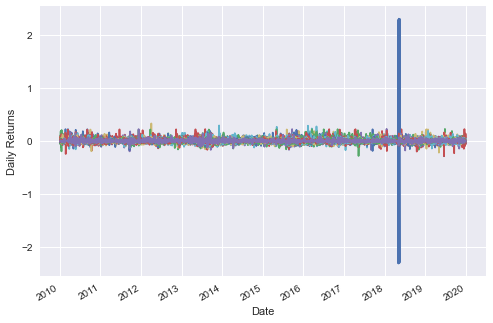

In [46]:
ret_all.plot(legend=False, ylabel='Daily Returns')

In [47]:
# ret_all.info()

### **Daily Price Movements**

In [48]:
open_price = df1['Open'][:training_year].dropna(how='all')
close_price = df1['Close'][:training_year].dropna(how='all')

In [49]:
daily_movt = log_rate(close_price/open_price).fillna(0)

In [50]:
daily_movt_corr=daily_movt.ewm(span=300).mean().corr()

In [51]:
daily_movt_dist=np.sqrt((1-daily_movt_corr)*2.0)

## **Volume**

In [52]:
stocks_volume = df1['Volume'][:training_year].dropna(how='all', axis=1)
stocks_volume_d_avg=stocks_volume.mean()
stocks_volume_total = stocks_volume.sum()

<AxesSubplot:xlabel='Date'>

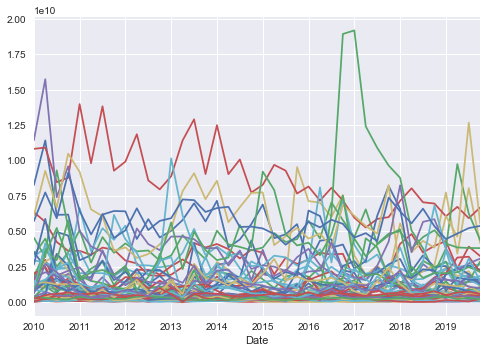

In [53]:
stocks_volume.resample('BQ').sum().plot(legend=False)

In [54]:
market_volume =  df2['Volume'][:training_year]
market_volume_d_avg=market_volume.mean()
market_volume_total = market_volume.sum()

In [55]:
avg_daily_volume_ratio = stocks_volume_d_avg / market_volume_d_avg
avg_daily_volume_ratio.sort_values()

GGRM.JK    0.000289
AALI.JK    0.000365
ITMG.JK    0.000412
ISAT.JK    0.000622
INTP.JK    0.000700
             ...   
BRPT.JK    0.017893
BBCA.JK    0.018370
TLKM.JK    0.024809
LPKR.JK    0.025263
BBRI.JK    0.037656
Length: 52, dtype: float64

In [56]:
total_volume_ratio = stocks_volume_total / market_volume_total
total_volume_ratio.sort_values()

GGRM.JK    0.000290
AALI.JK    0.000367
ITMG.JK    0.000414
ISAT.JK    0.000625
INTP.JK    0.000703
             ...   
BRPT.JK    0.017929
BBCA.JK    0.018452
TLKM.JK    0.024880
LPKR.JK    0.025335
BBRI.JK    0.037779
Length: 52, dtype: float64

In [57]:
volume_data = pd.DataFrame({'Total Vol. Ratio':total_volume_ratio, 
                            'Avg. Trading Vol. Ratio (Daily)':avg_daily_volume_ratio})
volume_data.sort_values(by='Total Vol. Ratio')

,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily)
GGRM.JK,0.000290,0.000289
AALI.JK,0.000367,0.000365
ITMG.JK,0.000414,0.000412
ISAT.JK,0.000625,0.000622
INTP.JK,0.000703,0.000700
...,...,...
BRPT.JK,0.017929,0.017893
BBCA.JK,0.018452,0.018370
TLKM.JK,0.024880,0.024809
LPKR.JK,0.025335,0.025263


In [58]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontweight='semibold', alpha=0.7)

# data_plot=volume_data

# fig, ax = plt.subplots(figsize = [10,8])
# ax = sns.scatterplot(x='Total Vol. Ratio', y='Avg. Trading Vol. Ratio (Daily)', 
#                 data=data_plot, s=100)
# ax.set_title('Trade Volume of Stocks vs Market Volume', fontsize=20)
# label_point(data_plot['Total Vol. Ratio'], data_plot['Avg. Trading Vol. Ratio (Daily)'],
#             data_plot.index.to_series(), ax)

### **Data Clean Up**

Here we can see that there are definite outliers in the data. To clean up the data, we caculate the _Z-score_ of each stock (column) and remove any value that has a _Z-score_ of above $\pm 3\sigma$.

In [59]:
from scipy import stats

In [60]:
ret = ret_all.apply(lambda col: col[np.abs(stats.zscore(col, nan_policy='omit')) < 3])
ret = ret.interpolate(method='time')

In [61]:
ret_ann = ret.resample('Y').sum()
ret_ann.index = ret_ann.index.strftime('%Y')

In [62]:
ret_mon = ret.resample('BM').sum()

In [63]:
sample=ret.sample(n=5, axis=1).columns

<AxesSubplot:xlabel='Date', ylabel='Daily Return Rate'>

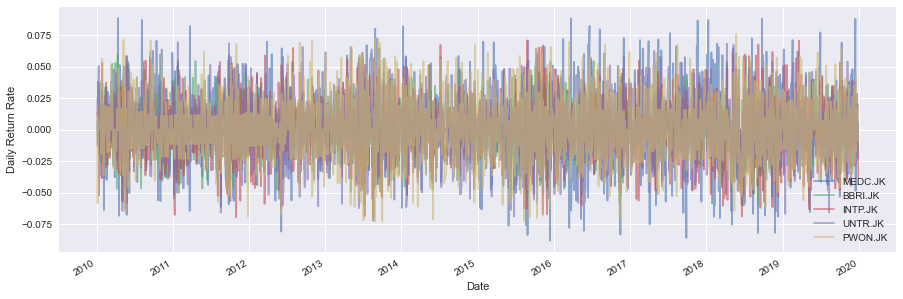

In [64]:
ret[sample].plot(ylabel='Daily Return Rate', alpha=0.6, figsize=(15,5))

In [65]:
ret[sample]

,MEDC.JK,BBRI.JK,INTP.JK,UNTR.JK,PWON.JK
Date,,,,,
2010-01-05,0.000000,0.006390,0.014337,0.025158,0.019048
2010-01-06,0.000000,-0.012821,0.010620,-0.003110,-0.058269
2010-01-07,0.000000,-0.012987,0.013986,-0.012539,-0.010050
2010-01-08,0.038100,0.006515,0.013793,0.034112,0.010050
2010-01-11,-0.009390,0.000000,0.016978,0.050531,0.000000
...,...,...,...,...,...
2019-12-20,0.000000,0.002296,0.011314,-0.022107,-0.008734
2019-12-23,0.028492,0.020432,-0.011314,-0.002356,-0.008811
2019-12-26,-0.011300,-0.009029,0.000000,0.019849,0.017544


<AxesSubplot:xlabel='Date', ylabel='Monthly Return Rate'>

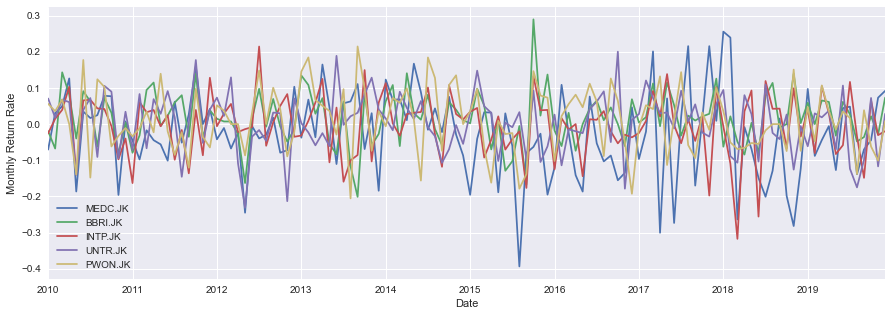

In [66]:
ret_mon[sample].plot(ylabel='Monthly Return Rate', figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Annual Return Rate'>

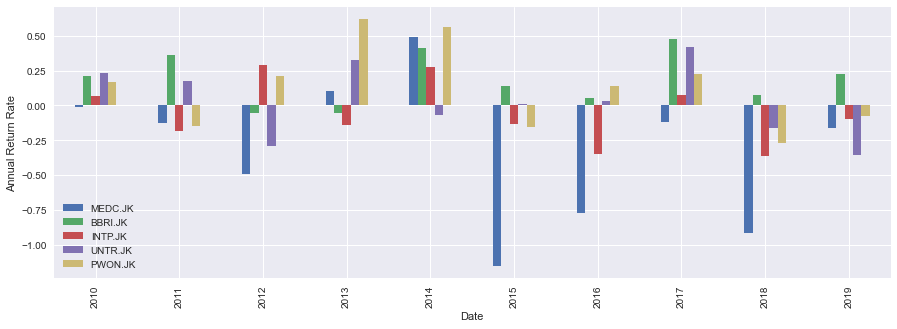

In [67]:
ret_ann[sample].plot(kind='bar', ylabel='Annual Return Rate',figsize=(15,5))

In [68]:
freq = ret.apply(lambda col: col.value_counts())

### **Distributions of Rate of Return**

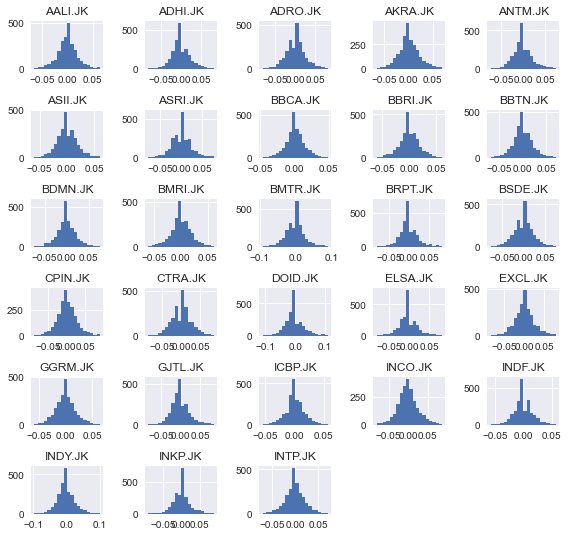

In [69]:
ret.iloc[:,:28].hist(bins=20,figsize=(8,16), layout=(13,5))
plt.tight_layout()

In [70]:
# ret.iloc[:,29:].hist(bins=20,figsize=(8,16), layout=(13,5))
# plt.tight_layout()

# **Correlation Matrix of Stocks**

In [71]:
corr_matrix = ret.corr()#.ewm(span=300).corr()
#corr_matrix = corr_matrix.loc[corr_matrix.index.levels[0][-1]]

In [72]:
# corr_matrix.info()

<AxesSubplot:>

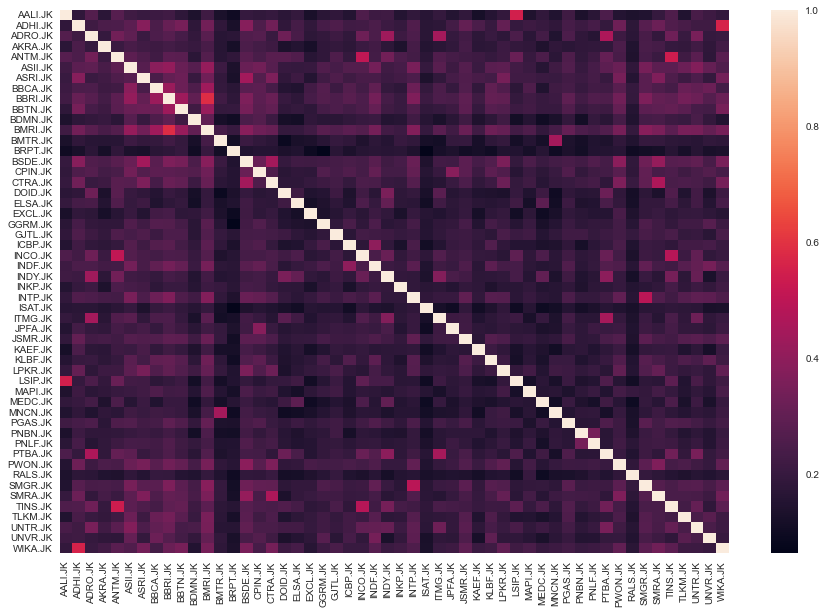

In [73]:
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix)

## **Correlation Score**

This is an _experimental_ variable where each stock is assigned a _score_ based on its average correlation value to other stocks in KOMPAS100. A low score may suggests that the stock is highly uncorrelated to other stocks and may help in building a highly diversified portfolio.

In [74]:
corr_score = corr_matrix.apply(lambda col: (col.sum() - 1 )/ (len(col)-1))
corr_score.sort_values().head(20)

BRPT.JK    0.137640
ISAT.JK    0.149635
RALS.JK    0.153923
EXCL.JK    0.169624
BMTR.JK    0.170241
MEDC.JK    0.172181
MNCN.JK    0.172657
KAEF.JK    0.174180
PNBN.JK    0.178864
DOID.JK    0.182687
INKP.JK    0.184690
ELSA.JK    0.185161
MAPI.JK    0.185588
BDMN.JK    0.185933
AALI.JK    0.191043
LSIP.JK    0.192539
PNLF.JK    0.193710
AKRA.JK    0.193833
JPFA.JK    0.196494
ICBP.JK    0.198685
dtype: float64

In [75]:
dist_matrix = np.sqrt((1-corr_matrix)*2)

<AxesSubplot:>

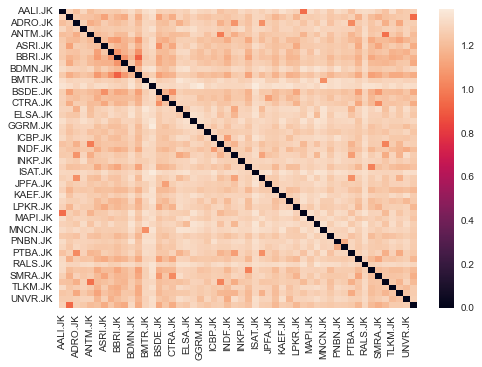

In [76]:
sns.heatmap(dist_matrix)

In [77]:
from scipy.spatial.distance import pdist
cond_dist_matrix = pdist(ret)

In [78]:
cond_dist_matrix

array([0.2407549 , 0.22807455, 0.17914825, ..., 0.12982004, 0.16695938,
       0.1727939 ])

## **Market (KOMPAS100 Index) Rate of Return**

In [79]:
market_price = df2[:training_year]['Close']
rate_market = log_rate(market_price).interpolate(method='time')
rate_market

Date
2010-01-05    0.012389
2010-01-06   -0.001602
2010-01-07   -0.006960
2010-01-08    0.010556
2010-01-11    0.006463
                ...   
2019-12-20    0.008202
2019-12-23    0.002771
2019-12-26    0.001667
2019-12-27    0.001338
2019-12-30   -0.007285
Name: Close, Length: 2450, dtype: float64

In [80]:
rate_market_ann=market_price.resample('Y').ffill().pct_change().dropna()

In [81]:
rate_market_annual = rate_market_ann.mean()

In [82]:
rate_market_annual

0.05188717732205609

<AxesSubplot:xlabel='Date', ylabel='Daily Return Rate'>

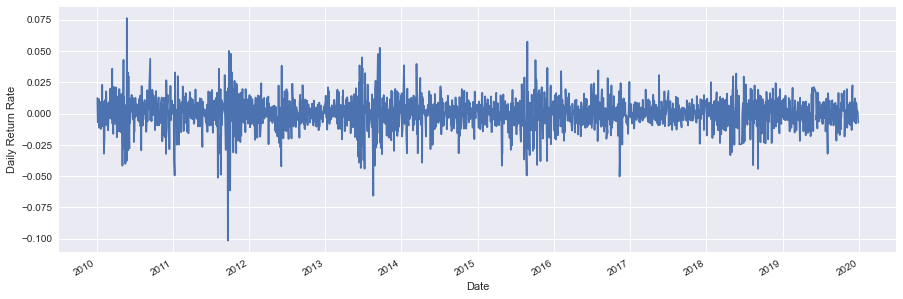

In [83]:
rate_market.plot(legend=False, ylabel='Daily Return Rate', figsize=(15,5))

## **Daily Bond Yield**

In [84]:
rate_bond = bond_yield['Close'][:training_year]
rate_bond.mean()

0.06260185291700894

In [85]:
daily_rf = (rate_bond)*(1/(365))
daily_rf

Date
2010-01-04    0.000207
2010-01-05    0.000174
2010-01-06    0.000185
2010-01-07    0.000170
2010-01-08    0.000181
                ...   
2019-12-20    0.000142
2019-12-23    0.000141
2019-12-26    0.000138
2019-12-27    0.000139
2019-12-30    0.000138
Name: Close, Length: 2434, dtype: float64

## **Excess Market Returns**

In [86]:
excess_ret_mar = ret.apply(lambda column: column-rate_market[rate_market.index.isin(column.index)]).dropna()

<AxesSubplot:xlabel='Date'>

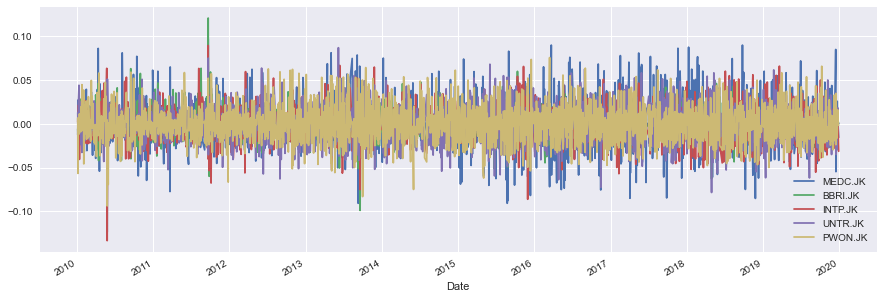

In [87]:
excess_ret_mar[sample].plot(figsize=(15,5))

In [88]:
excess_ret_mar

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002180,-0.037081,0.010211,-0.028918,-0.012389,-0.006739,0.006480,-0.002536,-0.005999,-0.012389,...,-0.012389,0.006660,0.060637,0.000683,0.005003,0.010868,-0.007167,0.012770,0.018794,-0.012389
2010-01-06,-0.002539,0.014024,0.007173,-0.006767,0.001602,-0.004048,0.001602,-0.028251,-0.011219,0.001602,...,0.023825,-0.056667,-0.026972,0.014505,0.018696,0.013031,-0.008870,-0.001509,-0.007209,0.001602
2010-01-07,0.045622,0.019230,0.028939,-0.009989,0.028466,-0.024697,0.016262,0.011998,-0.006027,0.006960,...,0.009703,-0.003091,-0.022454,-0.005943,0.006960,-0.004469,-0.019708,-0.005579,-0.010898,0.006960
2010-01-08,-0.002604,0.001565,0.052623,-0.019140,-0.010556,-0.004725,0.016843,-0.036003,-0.004042,0.021192,...,-0.007820,-0.000506,-0.025594,-0.017071,-0.010556,-0.010556,0.000197,0.023556,-0.006062,-0.025824
2010-01-11,-0.018415,-0.018584,0.003689,0.010631,-0.017158,0.009399,0.046181,0.003794,-0.006463,-0.027516,...,-0.017452,-0.006463,-0.037235,0.006524,-0.006463,0.004966,0.004176,0.044068,0.002466,-0.006463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.008573,-0.016501,-0.043294,0.006988,-0.014208,0.002687,-0.041263,0.000848,-0.005906,-0.017548,...,-0.027250,-0.016936,-0.047423,-0.024235,-0.023165,-0.020398,0.022103,-0.030309,0.014271,-0.023240
2019-12-23,0.002759,-0.015350,0.022871,-0.007809,-0.008813,-0.006388,-0.002771,-0.002771,0.017661,-0.007477,...,0.001068,-0.011582,0.046019,-0.012924,-0.002771,-0.002771,-0.002771,-0.005127,-0.002171,-0.010376
2019-12-26,0.034438,-0.005895,0.001493,0.000855,0.016352,-0.005297,0.006701,0.001332,-0.010696,0.003039,...,0.009762,0.015877,-0.001667,0.004437,0.003346,0.010528,-0.006654,0.018182,0.017359,0.010976


## **Market Premium**

In [89]:
market_premium = (rate_market[rate_market.index.isin(daily_rf.index)] - daily_rf).dropna()
market_premium.mean()

0.000111834645280038

<AxesSubplot:xlabel='Date'>

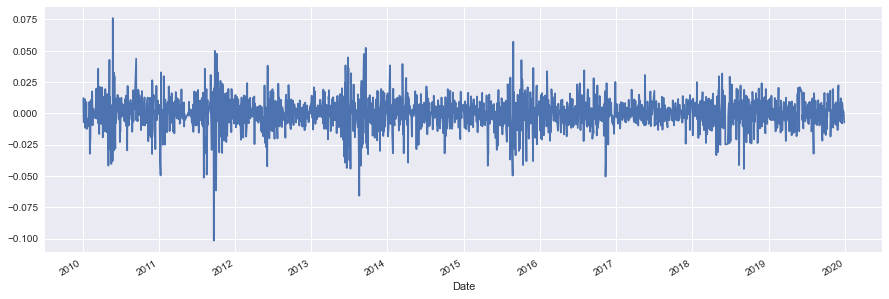

In [90]:
market_premium.plot(figsize=(15,5))

In [91]:
market_premium.sort_values()

Date
2011-09-22   -0.101680
2013-08-19   -0.065799
2011-10-03   -0.061567
2011-08-05   -0.051411
2016-11-11   -0.050456
                ...   
2011-10-06    0.047585
2011-09-27    0.049916
2013-09-19    0.052321
2015-08-27    0.057259
2010-05-26    0.076126
Name: Close, Length: 2433, dtype: float64

## **Risk Premium**

In [92]:
risk_premium = ret.apply(lambda column: column-daily_rf[daily_rf.index.isin(column.index)]).dropna()

<AxesSubplot:xlabel='Date'>

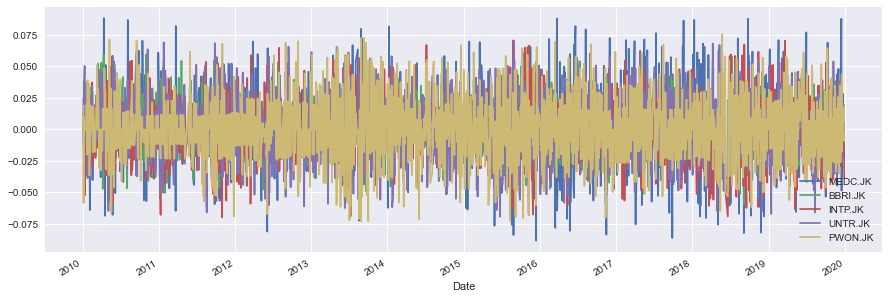

In [93]:
risk_premium[sample].plot(figsize=(15,5))

In [94]:
risk_premium

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014395,-0.024867,0.022426,-0.016703,-0.000174,0.005476,0.018695,0.009679,0.006216,-0.000174,...,-0.000174,0.018874,0.072852,0.012898,0.017218,0.023083,0.005048,0.024984,0.031009,-0.000174
2010-01-06,-0.004325,0.012238,0.005387,-0.008553,-0.000185,-0.005834,-0.000185,-0.030038,-0.013005,-0.000185,...,0.022038,-0.058454,-0.028758,0.012719,0.016910,0.011244,-0.010656,-0.003295,-0.008996,-0.000185
2010-01-07,0.038492,0.012100,0.021809,-0.017119,0.021336,-0.031827,0.009132,0.004868,-0.013157,-0.000170,...,0.002573,-0.010220,-0.029584,-0.013073,-0.000170,-0.011599,-0.026838,-0.012709,-0.018027,-0.000170
2010-01-08,0.007771,0.011940,0.062998,-0.008765,-0.000181,0.005650,0.027218,-0.025628,0.006334,0.031568,...,0.002555,0.009869,-0.015219,-0.006696,-0.000181,-0.000181,0.010572,0.033931,0.004313,-0.015449
2010-01-11,-0.012133,-0.012301,0.009972,0.016914,-0.010875,0.015682,0.052464,0.010076,-0.000180,-0.021234,...,-0.011169,-0.000180,-0.030952,0.012807,-0.000180,0.011249,0.010458,0.050351,0.008748,-0.000180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.016634,-0.008441,-0.035233,0.015049,-0.006148,0.010748,-0.033203,0.008908,0.002155,-0.009487,...,-0.019190,-0.008875,-0.039362,-0.016174,-0.015105,-0.012337,0.030164,-0.022248,0.022331,-0.015180
2019-12-23,0.005389,-0.012720,0.025502,-0.005179,-0.006183,-0.003758,-0.000141,-0.000141,0.020291,-0.004847,...,0.003698,-0.008952,0.048649,-0.010293,-0.000141,-0.000141,-0.000141,-0.002497,0.000459,-0.007746
2019-12-26,0.035968,-0.004366,0.003022,0.002384,0.017881,-0.003768,0.008231,0.002861,-0.009167,0.004568,...,0.011291,0.017407,-0.000138,0.005966,0.004875,0.012058,-0.005125,0.019711,0.018888,0.012505


In [95]:
def reg_plot(x,y):
    exog = x[x.index.isin(y.index)]
    endog = y[y.index.isin(x.index)]
    reg_analysis=pd.DataFrame({'Risk Premium': endog, 'Market Premium':exog})
    fig, ax = plt.subplots()
    sns.regplot(x='Market Premium', y= 'Risk Premium', data= reg_analysis, ci=None,\
            line_kws={'color':'r'},scatter_kws={"s": 20}, ax=ax)
    ax.axhline(y=0, color='k', linewidth=1)  
    ax.axvline(x=0, color='k', linewidth=1)

In [ ]:
y = risk_premium['BBCA.JK'].loc['2018']
x = market_premium.loc['2018']
reg_plot(x,y)

## **Daily Sharpe**

In [ ]:
daily_sr = (risk_premium/daily_movt)

In [ ]:
daily_sr.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
daily_sr.dropna(inplace=True)

## **Instruments Analysis**

In [ ]:
def lin_regression(asset_ret, market_ret):
    stock = asset_ret[asset_ret.index.isin(market_ret.index)] 
    market = market_ret[market_ret.index.isin(stock.index)] 
    reg = stock.apply(lambda col: stats.linregress(col.dropna(), market[market.index.isin(col.dropna().index)]))
    return reg

In [ ]:
#Training Data
train_ret = ret[:training_year]
res= pd.DataFrame()
metrics =pd.DataFrame()
sharpe =pd.DataFrame()

for year in range(2010, int(training_year)):
    
    yr = f'{year}'

    #Covariances
    tr_cov = train_ret[:yr].cov()
    tr_std = train_ret[:yr].std()
    tr_semicov = train_ret[:yr][train_ret[:yr] < 0].cov()
    tr_mar_cov = train_ret[:yr].apply(lambda col: col.cov(rate_market[:yr]))
    tr_mar_var = rate_market[:yr].var()

    #Regression
    tr_y = risk_premium.loc[:yr]
    tr_x = market_premium.loc[:yr]
    reg = lin_regression(tr_y,tr_x)
    tr_alpha = reg.iloc[1]
    tr_beta = reg.iloc[0]
    tr_rsq = reg.iloc[2]
    tr_sse = reg.iloc[4]


    #Expected Returns Market
    tr_market_er = rate_market[:yr].mean()*252
    tr_risk_free = daily_rf[:yr].mean()*365
    tr_er_marketprem = (tr_market_er - tr_risk_free)

    #CAPM Beta 
    tr_beta_stat = tr_mar_cov.divide(tr_mar_var)

    #LReg Expected Return
    tr_beta_prem = tr_beta.apply(lambda x: x*(market_premium.loc[yr])).T
    tr_lreg_ret = tr_alpha + tr_beta_prem.sum() + tr_risk_free
    tr_exp_ret = tr_lreg_ret

    #CAPM Expected Return
    tr_beta_prem_stat = tr_beta_stat*tr_er_marketprem
    tr_ols = (tr_beta_prem_stat + tr_risk_free)
    tr_exp_ret_stat = tr_ols

    #Annualised Return
    tr_mean_ret = train_ret[:yr].mean()
    tr_ind_er = tr_mean_ret*(252)
    
    #Exponentially Weighted Return
    tr_300ewm_ret = train_ret[:yr].ewm(span=300).mean().iloc[-1]
    tr_300ewm_er = tr_300ewm_ret*252
    tr_500ewm_ret = train_ret[:yr].ewm(span=500).mean().iloc[-1]
    tr_500ewm_er = tr_500ewm_ret*252
    
    #Ex-ante Sharpe
    tr_sharpe_ante = (tr_exp_ret - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_capm = (tr_exp_ret_stat - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_ann = (tr_ind_er - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_300ewm = (tr_300ewm_er - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_500ewm = (tr_500ewm_er - tr_risk_free)/(tr_std*np.sqrt(252))
    
    #Real Return 2019
    tr_ret = ret_ann.loc[f'{year+1}']
    tr_real_std = ret.loc[f'{year+1}'].std()
    
    #Ex-post Sharpe
    tr_sharpe_post = (tr_ret - tr_risk_free)/(tr_real_std*np.sqrt(252))    
    
    rets_data = pd.DataFrame({'Exp. Ret. (LinReg)': tr_exp_ret, 'Exp. Ret. (OLS)': tr_exp_ret_stat, 'Exp. Annualised Return': tr_ind_er, 'Exp. 300 EMA Return':tr_300ewm_er,'Exp. 500 EMA Return':tr_500ewm_er,
                              'Realised Return': tr_ret}).T.stack()
    metrics_data = pd.DataFrame({'Beta(CAPM)':tr_beta_stat, 'Beta (LinReg)': tr_beta, 'Alpha (LinReg)':tr_alpha}).T.stack()
    sharpe_data = pd.DataFrame({'Ex-Ante Sharpe LinReg':tr_sharpe_ante, 'Ex-Ante Sharpe CAPM':tr_sharpe_ante_capm, 'Ex-Ante Sharpe AnnRet':tr_sharpe_ante_ann, 
                                'Ex-Ante Sharpe 300 EMA':tr_sharpe_ante_300ewm, 'Ex-Ante Sharpe 500 EMA':tr_sharpe_ante_500ewm,'Ex-Post Sharpe':tr_sharpe_post}).T.stack()
    
    res[f'{year+1}'] = rets_data
    metrics[f'{year+1}'] = metrics_data
    sharpe[f'{year+1}'] = sharpe_data


In [ ]:
res_mean_ann=res.groupby(axis=0, level=0).mean().T

In [ ]:
res_mean_ann.plot(kind='bar')

In [ ]:
ttest_rets = res_mean_ann.apply(lambda col: stats.ttest_ind(col, res_mean_ann['Realised Return']))
ttest_rets.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [ ]:
ttest_rets

In [ ]:
res_mean_ann.corr()

In [ ]:
res_mean_ann.apply(lambda col: (np.square(res_mean_ann['Realised Return']-col)).mean())

In [ ]:
metrics

<AxesSubplot:>

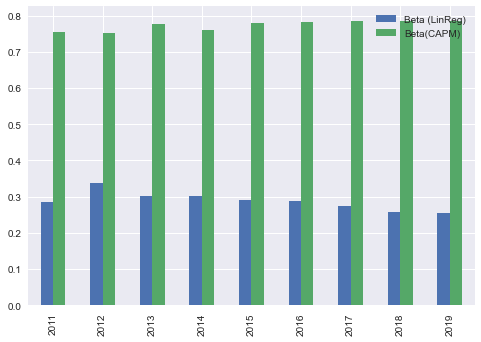

In [109]:
annual_betas = metrics.groupby(level=0).mean().drop('Alpha (LinReg)')
annual_betas.T.plot(kind='bar')

In [110]:
sharpe

2011      2012      2013      2014  \
Ex-Ante Sharpe LinReg AALI.JK  0.266629 -0.032314  0.063055 -0.076436   
                      ADHI.JK  0.145850 -0.018978  0.037082 -0.046800   
                      ADRO.JK  0.248100 -0.024420  0.056155 -0.065995   
                      AKRA.JK  0.193858 -0.026635  0.052734 -0.069815   
                      ANTM.JK  0.271133 -0.036430  0.080957 -0.087853   
...                                 ...       ...       ...       ...   
Ex-Post Sharpe        TINS.JK -0.476029  0.013805  0.046679  0.048148   
                      TLKM.JK -0.496375  0.472110  0.266452  1.397363   
                      UNTR.JK  0.329041 -1.038409  0.756506 -0.388564   
                      UNVR.JK  0.829238  0.242616 -0.318101  0.817672   
                      WIKA.JK -0.693263  1.842115 -0.334740  2.520315   

                                   2015      2016      2017      2018  \
Ex-Ante Sharpe LinReg AALI.JK  0.164075 -0.162751  0.059024  0.112707   
                      ADHI.JK  0.109524 -0.120972  0.048477  0.088817   
                      ADRO.JK  0.134080 -0.135833  0.046072  0.084152   
                      AKRA.JK  0.154288 -0.155945  0.055609  0.100162   
                      ANTM.JK  0.191109 -0.190948  0.069803  0.120865   
...                                 ...       ...       ...       ...   
Ex-Post Sharpe        TINS.JK -2.378450  0.814016 -1.915709 -0.424390   
                      TLKM.JK -0.179853  0.554668 -0.491843 -0.708107   
                      UNTR.JK -0.122402 -0.083338  1.043249 -0.649229   
                      UNVR.JK -0.361178  0.588835  1.873399 -0.742561   
                      WIKA.JK -1.806500 -0.680937 -1.725066  0.175449   

                                   2019  
Ex-Ante Sharpe LinReg AALI.JK -0.077745  
                      ADHI.JK -0.066106  
                      ADRO.JK -0.060178  
                      AKRA.JK -0.074276  
                      ANTM.JK -0.084700  
...                                 ...  
Ex-Post Sharpe        TINS.JK -1.827072  
                      TLKM.JK  0.035647  
                      UNTR.JK -1.320253  
                      UNVR.JK -0.500652  
                      WIKA.JK  0.534987  

[312 rows x 9 columns]

In [111]:
sharpe_mean_ann=sharpe.groupby(axis=0, level=0).mean().T

In [112]:
ttest_sharpe = sharpe_mean_ann.apply(lambda col: stats.ttest_ind(col, sharpe_mean_ann['Ex-Post Sharpe']))
ttest_sharpe.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [113]:
ttest_sharpe

,Ex-Ante Sharpe 300 EMA,Ex-Ante Sharpe 500 EMA,Ex-Ante Sharpe AnnRet,Ex-Ante Sharpe CAPM,Ex-Ante Sharpe LinReg,Ex-Post Sharpe
t-statistics,0.092782,0.337373,1.548335,2.439514,1.746910,0.0
p-value,0.927229,0.740221,0.141093,0.026728,0.099817,1.0


## **Instruments Calculations**

In [114]:
cov = ret.cov()

In [115]:
semicov = ret[ret < 0].cov()

In [116]:
mar_cov = ret.apply(lambda col: col.cov(rate_market[rate_market.index.isin(col.index)]))
mar_cov

AALI.JK    0.000087
ADHI.JK    0.000133
ADRO.JK    0.000137
AKRA.JK    0.000102
ANTM.JK    0.000117
             ...   
TINS.JK    0.000129
TLKM.JK    0.000103
UNTR.JK    0.000135
UNVR.JK    0.000104
WIKA.JK    0.000124
Length: 52, dtype: float64

In [117]:
mar_var = rate_market.var()
mar_var

0.00014734133787240835

In [118]:
y = risk_premium
x = market_premium
reg = lin_regression(y,x)

In [119]:
alpha = reg.iloc[1]
beta = reg.iloc[0]
rsq = reg.iloc[2]
sse = reg.iloc[4]

In [120]:
beta.sort_values()

DOID.JK    0.122330
BRPT.JK    0.140734
MEDC.JK    0.148307
RALS.JK    0.152000
BMTR.JK    0.157946
             ...   
TLKM.JK    0.388652
ASII.JK    0.400088
BBRI.JK    0.425206
BMRI.JK    0.428710
BBCA.JK    0.507507
Name: 0, Length: 52, dtype: float64

In [121]:
alpha.sort_values()

BBCA.JK   -0.000184
BBRI.JK   -0.000147
CPIN.JK   -0.000125
KLBF.JK   -0.000092
MAPI.JK   -0.000079
             ...   
GJTL.JK    0.000328
ELSA.JK    0.000352
INDY.JK    0.000383
ANTM.JK    0.000412
DOID.JK    0.000459
Name: 1, Length: 52, dtype: float64

In [122]:
rsq.sort_values()

BRPT.JK    0.261051
MEDC.JK    0.301208
ISAT.JK    0.305634
RALS.JK    0.309053
ELSA.JK    0.315736
             ...   
TLKM.JK    0.521130
BBCA.JK    0.598001
ASII.JK    0.615128
BBRI.JK    0.641504
BMRI.JK    0.658288
Name: 2, Length: 52, dtype: float64

In [123]:
sse

AALI.JK    0.011646
ADHI.JK    0.009268
ADRO.JK    0.008785
AKRA.JK    0.010575
ANTM.JK    0.010280
             ...   
TINS.JK    0.009254
TLKM.JK    0.012944
UNTR.JK    0.009789
UNVR.JK    0.012686
WIKA.JK    0.009692
Name: 4, Length: 52, dtype: float64

In [124]:
market_er = rate_market.mean()*252
risk_free = daily_rf.mean()*252
er_marketprem = (market_er - risk_free)

In [125]:
er_marketprem

0.030578077448314867

In [126]:
beta_stat = mar_cov.divide(mar_var)
beta_stat

AALI.JK    0.591624
ADHI.JK    0.901060
ADRO.JK    0.932086
AKRA.JK    0.694903
ANTM.JK    0.793994
             ...   
TINS.JK    0.877070
TLKM.JK    0.700478
UNTR.JK    0.914988
UNVR.JK    0.707158
WIKA.JK    0.843771
Length: 52, dtype: float64

In [127]:
beta_prem = beta.apply(lambda row: row*market_premium[training_year]).T

In [128]:
beta_prem

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.000043,-0.000045,-0.000042,-0.000042,-0.000049,-0.000077,-0.000045,-0.000098,-0.000082,-0.000056,...,-0.000043,-0.000049,-0.000029,-0.000059,-0.000041,-0.000043,-0.000075,-0.000055,-0.000072,-0.000046
2019-01-03,0.001824,0.001937,0.001770,0.001811,0.002070,0.003277,0.001905,0.004157,0.003483,0.002380,...,0.001829,0.002070,0.001245,0.002518,0.001746,0.001838,0.003184,0.002335,0.003060,0.001965
2019-01-04,0.002453,0.002606,0.002380,0.002436,0.002785,0.004408,0.002562,0.005592,0.004685,0.003202,...,0.002460,0.002785,0.001675,0.003387,0.002348,0.002473,0.004282,0.003140,0.004116,0.002643
2019-01-07,0.000761,0.000808,0.000738,0.000756,0.000864,0.001368,0.000795,0.001735,0.001453,0.000993,...,0.000763,0.000864,0.000520,0.001051,0.000729,0.000767,0.001328,0.000974,0.001277,0.000820
2019-01-08,-0.001064,-0.001130,-0.001032,-0.001056,-0.001207,-0.001911,-0.001111,-0.002425,-0.002031,-0.001388,...,-0.001067,-0.001207,-0.000726,-0.001469,-0.001018,-0.001072,-0.001857,-0.001362,-0.001785,-0.001146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.001795,0.001906,0.001741,0.001782,0.002037,0.003225,0.001874,0.004091,0.003427,0.002342,...,0.001800,0.002037,0.001225,0.002478,0.001718,0.001809,0.003133,0.002297,0.003011,0.001933
2019-12-23,0.000586,0.000622,0.000568,0.000582,0.000665,0.001052,0.000612,0.001335,0.001118,0.000764,...,0.000587,0.000665,0.000400,0.000809,0.000561,0.000590,0.001022,0.000750,0.000982,0.000631
2019-12-26,0.000340,0.000362,0.000330,0.000338,0.000386,0.000612,0.000356,0.000776,0.000650,0.000444,...,0.000341,0.000386,0.000232,0.000470,0.000326,0.000343,0.000594,0.000436,0.000571,0.000367


In [129]:
beta_prem_stat = (beta_stat*er_marketprem)

In [130]:
beta_prem_stat.sort_values()

BRPT.JK    0.015004
ISAT.JK    0.016484
AALI.JK    0.018091
ELSA.JK    0.018900
MEDC.JK    0.018922
             ...   
BSDE.JK    0.030280
SMRA.JK    0.030428
BMRI.JK    0.031092
CTRA.JK    0.031129
CPIN.JK    0.033921
Length: 52, dtype: float64

In [131]:
lreg_ret = alpha + beta_prem.apply(lambda col: col + daily_rf)

In [132]:
exp_ret = lreg_ret.sum()

In [133]:
exp_ret = lreg_ret.sum()

In [134]:
exp_ret.sort_values()

BBCA.JK   -0.016759
BBRI.JK   -0.005467
CPIN.JK    0.005184
KLBF.JK    0.010913
INDF.JK    0.017219
             ...   
MEDC.JK    0.118153
ELSA.JK    0.123749
INDY.JK    0.131055
ANTM.JK    0.136095
DOID.JK    0.151021
Length: 52, dtype: float64

In [135]:
ols = (beta_prem_stat + risk_free)

In [136]:
exp_ret_stat = ols
exp_ret_stat.sort_values()

BRPT.JK    0.058225
ISAT.JK    0.059705
AALI.JK    0.061312
ELSA.JK    0.062121
MEDC.JK    0.062143
             ...   
BSDE.JK    0.073501
SMRA.JK    0.073649
BMRI.JK    0.074313
CTRA.JK    0.074350
CPIN.JK    0.077142
Length: 52, dtype: float64

In [137]:
ret.resample('Y').sum().iloc[-1]

AALI.JK    0.297488
ADHI.JK   -0.273038
ADRO.JK    0.172363
AKRA.JK   -0.092504
ANTM.JK   -0.190808
             ...   
TINS.JK   -0.730165
TLKM.JK    0.070687
UNTR.JK   -0.352360
UNVR.JK   -0.049780
WIKA.JK    0.265568
Name: 2019-12-31 00:00:00, Length: 52, dtype: float64

In [138]:
real_ret = ret_ann.iloc[-1]
real_ret.sort_values()

KAEF.JK   -1.168226
INKP.JK   -1.043406
DOID.JK   -0.810615
TINS.JK   -0.730165
INDY.JK   -0.609629
             ...   
AALI.JK    0.297488
PGAS.JK    0.341031
EXCL.JK    0.362568
BRPT.JK    0.803392
MNCN.JK    0.891767
Name: 2019, Length: 52, dtype: float64

In [139]:
ewm300 = ret.ewm(span=300).mean()

In [140]:
ewm300_er = ewm300.iloc[-1]*252

In [141]:
mean_ret = ret.mean()

In [142]:
ind_er = mean_ret*252
ind_er.sort_values()

DOID.JK   -0.677764
INDY.JK   -0.353874
ELSA.JK   -0.340159
MEDC.JK   -0.321109
ANTM.JK   -0.259027
             ...   
BBRI.JK    0.188171
AKRA.JK    0.195625
KLBF.JK    0.207216
CPIN.JK    0.293456
MAPI.JK    0.295813
Length: 52, dtype: float64

In [143]:
returns = pd.DataFrame({'Exp. Ret. (LinReg)': exp_ret, 'Exp. Ret. (OLS)': exp_ret_stat, 'Annualised Return': ind_er, 'EMA-300 Return': ewm300_er, 'Realised Return':real_ret})

In [144]:
returns.mean()#.plot(kind='bar')

Exp. Ret. (LinReg)    0.070165
Exp. Ret. (OLS)       0.067534
Annualised Return    -0.024271
EMA-300 Return       -0.125330
Realised Return      -0.078518
dtype: float64

In [145]:
returns.sample(n=10)

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
MEDC.JK,0.118153,0.062143,-0.321109,-0.240465,-0.163382
BMRI.JK,0.024684,0.074313,0.124663,0.122796,0.075776
BDMN.JK,0.083538,0.066576,-0.055250,-0.190675,-0.074327
BBCA.JK,-0.016759,0.064970,0.183608,0.278363,0.263467
AKRA.JK,0.028059,0.064470,0.195625,-0.189718,-0.092504
UNVR.JK,0.028583,0.064845,0.121556,-0.079321,-0.049780
LSIP.JK,0.087778,0.062715,-0.098273,0.031463,-0.145958
KAEF.JK,0.101049,0.065411,-0.192575,-1.706978,-1.168226
PTBA.JK,0.072644,0.068406,-0.007722,-0.067069,-0.386404
ASRI.JK,0.075717,0.070022,-0.012209,-0.392676,-0.270733


In [146]:
returns.corr()

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
Exp. Ret. (LinReg),1.000000,-0.212544,-0.934102,-0.465557,-0.404728
Exp. Ret. (OLS),-0.212544,1.000000,0.240789,-0.007505,-0.091421
Annualised Return,-0.934102,0.240789,1.000000,0.492361,0.437845
EMA-300 Return,-0.465557,-0.007505,0.492361,1.000000,0.889586
Realised Return,-0.404728,-0.091421,0.437845,0.889586,1.000000


In [147]:
returns.cov()

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
Exp. Ret. (LinReg),0.001385,-0.000033,-0.006171,-0.006710,-0.005687
Exp. Ret. (OLS),-0.000033,0.000017,0.000178,-0.000012,-0.000144
Annualised Return,-0.006171,0.000178,0.031524,0.033857,0.029353
EMA-300 Return,-0.006710,-0.000012,0.033857,0.150004,0.130094
Realised Return,-0.005687,-0.000144,0.029353,0.130094,0.142573


In [148]:
ttest_rets = returns.apply(lambda col: stats.ttest_ind(col, real_ret))

In [149]:
ttest_rets.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [150]:
ttest_rets

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
t-statistics,2.825816,2.789107,0.937510,-0.624080,0.0
p-value,0.005675,0.006307,0.350711,0.533968,1.0


In [151]:
returns.apply(lambda col: (np.square(returns['Realised Return']-col)).mean())

Exp. Ret. (LinReg)    0.174450
Exp. Ret. (OLS)       0.161461
Annualised Return     0.116113
EMA-300 Return        0.033957
Realised Return       0.000000
dtype: float64

In [152]:
ann_mon_er = ret_mon.apply(lambda col: col.mean()*12)
ann_mon_er.sort_values()

DOID.JK   -0.664317
INDY.JK   -0.346852
ELSA.JK   -0.333410
MEDC.JK   -0.314738
ANTM.JK   -0.253888
             ...   
BBRI.JK    0.184437
AKRA.JK    0.191744
KLBF.JK    0.203105
CPIN.JK    0.287633
MAPI.JK    0.289944
Length: 52, dtype: float64

In [153]:
ret_ann.tail(3).mean().sort_values()

KAEF.JK   -0.659110
ISAT.JK   -0.577040
TINS.JK   -0.459109
LPKR.JK   -0.413950
MEDC.JK   -0.397675
             ...   
BBRI.JK    0.256810
BBCA.JK    0.281451
CPIN.JK    0.294117
INKP.JK    0.440718
BRPT.JK    0.572277
Length: 52, dtype: float64

### **Ex-Ante Statistics**

In [154]:
exp_sd = ret.ewm(span=300).std().iloc[-1]*np.sqrt(252)
exp_semisd= ret[ret<0].ewm(span=300).std().iloc[-1]*np.sqrt(252)

In [155]:
exp_sd

AALI.JK    0.285881
ADHI.JK    0.315725
ADRO.JK    0.409746
AKRA.JK    0.313855
ANTM.JK    0.371948
             ...   
TINS.JK    0.402781
TLKM.JK    0.238196
UNTR.JK    0.322260
UNVR.JK    0.226025
WIKA.JK    0.386134
Name: 2019-12-30 00:00:00, Length: 52, dtype: float64

In [156]:
exp_excess_ret = ewm300_er - risk_free
exp_sharpe = exp_excess_ret / exp_sd
exp_sortino = exp_excess_ret / exp_semisd

In [157]:
exp_sharpe.sort_values()

KAEF.JK   -3.941737
TINS.JK   -1.840906
DOID.JK   -1.824082
INDY.JK   -1.579290
ISAT.JK   -1.576198
             ...   
PGAS.JK    1.011321
MNCN.JK    1.210979
AALI.JK    1.398062
BBCA.JK    1.424703
BRPT.JK    1.823872
Name: 2019-12-30 00:00:00, Length: 52, dtype: float64

### **Ex-Post Statistics**

In [158]:
ann_sd = ret.std()*np.sqrt(252)
ann_sd.sort_values()

BBCA.JK    0.226730
TLKM.JK    0.257104
UNVR.JK    0.263238
JSMR.JK    0.263462
ICBP.JK    0.269484
             ...   
CPIN.JK    0.420825
MAPI.JK    0.424648
CTRA.JK    0.425832
INDY.JK    0.428165
DOID.JK    0.502836
Length: 52, dtype: float64

In [159]:
ann_semisd = ret[ret<0].std()*np.sqrt(252)
ann_semisd.sort_values()

BBCA.JK    0.155702
JSMR.JK    0.160652
TLKM.JK    0.169750
UNVR.JK    0.172561
INDF.JK    0.173963
             ...   
BMTR.JK    0.262326
INDY.JK    0.262932
CPIN.JK    0.264160
INKP.JK    0.265601
DOID.JK    0.310568
Length: 52, dtype: float64

In [160]:
_expret = ind_er
excess_ret_rf = _expret - risk_free
ann_sharpe = excess_ret_rf.div(ann_sd)
ann_sharpe.sort_values()

DOID.JK   -1.433838
ELSA.JK   -1.027696
MEDC.JK   -0.935813
INDY.JK   -0.927435
ANTM.JK   -0.892002
             ...   
BBRI.JK    0.500083
KLBF.JK    0.567485
CPIN.JK    0.594628
MAPI.JK    0.594828
BBCA.JK    0.619184
Length: 52, dtype: float64

In [161]:
ann_sortino = excess_ret_rf.divide(ann_semisd)
ann_sortino

AALI.JK   -0.897449
ADHI.JK   -0.215970
ADRO.JK   -0.160733
AKRA.JK    0.751940
ANTM.JK   -1.475768
             ...   
TINS.JK   -0.970264
TLKM.JK    0.121659
UNTR.JK   -0.044599
UNVR.JK    0.453952
WIKA.JK    0.390510
Length: 52, dtype: float64

In [162]:
exp_exretmar = _expret - (market_er)
ann_infratio = exp_exretmar.div(ann_sd)
ann_infratio.sort_values()

DOID.JK   -1.494649
ELSA.JK   -1.109664
MEDC.JK   -1.014355
INDY.JK   -0.998851
ANTM.JK   -0.982244
             ...   
BBRI.JK    0.394587
KLBF.JK    0.461673
BBCA.JK    0.484319
CPIN.JK    0.521966
MAPI.JK    0.522819
Length: 52, dtype: float64

In [163]:
ann_riskprem = risk_premium.mean()*252

In [164]:
ret_skew = ret.skew(axis=0)

In [165]:
ret_kurt = ret.kurtosis(axis=0)

In [166]:
ret_kurt

AALI.JK    1.024341
ADHI.JK    1.067771
ADRO.JK    0.700447
AKRA.JK    0.595228
ANTM.JK    1.075841
             ...   
TINS.JK    0.928502
TLKM.JK    0.697553
UNTR.JK    0.450074
UNVR.JK    0.946078
WIKA.JK    0.760921
Length: 52, dtype: float64

In [223]:
assets = pd.concat([exp_ret, exp_ret_stat, ind_er, ewm300_er, ret_mon[-3:-1].sum(), ret_mon[-6:-1].sum(), ret_ann[-2:-1].sum(), ann_sd,
                    ann_semisd, ann_sharpe, exp_sharpe, ann_sortino, ann_infratio, ret_skew, ret_kurt, alpha, beta, beta_stat, rsq, mcap, total_volume_ratio, real_ret], axis=1) # Creating a table for visualising returns and volatility of assets

assets.columns = ['Expected Return (LinReg)', 'Expected Return (CAPM)',  'Annualised Return', 'EMA-300 Return', 'Last 3 Months Change', 'Last 6 Months Change', 
                  'Last 2 Year Change','Annualised Volatility', 'Annualised Downside Risk', 'Sharpe', 'Expected Sharpe', 'Sortino', 'Info. Ratio', 'Skew', 'Kurtosis', 'Alpha', 'Beta', 'Beta (CAPM)','R2',
                  'Market Cap', 'Volume-to-Market Ratio','Realised Return']
assets.sample(n=10).sort_values(by='Expected Return (CAPM)', ascending=False)

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
SMRA.JK,0.051982,0.073649,0.088460,-0.176577,-0.124298,-0.175069,-0.424776,0.413472,0.247609,0.109412,...,0.035457,0.102506,0.367919,0.000065,0.213125,0.995085,0.460178,1.387000e+13,0.005680,0.140691
INTP.JK,0.090522,0.071398,-0.055329,-0.161449,0.035413,-0.030459,-0.359421,0.338474,0.224260,-0.291159,...,-0.381500,0.004406,0.736383,0.000231,0.294674,0.921484,0.519873,3.957000e+13,0.000703,-0.095356
ADHI.JK,0.071826,0.070774,-0.005194,-0.327584,-0.216611,-0.449445,-0.243048,0.373173,0.224174,-0.129739,...,-0.211680,0.267908,1.067771,0.000148,0.236501,0.901060,0.460619,2.920000e+12,0.004496,-0.273038
INDY.JK,0.131055,0.070381,-0.353874,-0.641173,-0.192257,-0.437214,-0.792015,0.428165,0.262932,-0.927435,...,-0.998851,0.282219,1.148304,0.000383,0.176901,0.888202,0.395648,7.150000e+12,0.004249,-0.609629
PTBA.JK,0.072644,0.068406,-0.007722,-0.067069,0.068403,-0.201422,0.777129,0.366975,0.230410,-0.138819,...,-0.222143,0.134475,0.790678,0.000150,0.223253,0.823633,0.427595,2.628000e+13,0.004812,-0.386404
BMTR.JK,0.099633,0.066489,-0.191185,-0.159457,-0.054394,-0.149704,-0.881615,0.420301,0.262326,-0.557711,...,-0.630463,0.224777,1.040798,0.000253,0.157946,0.760951,0.345541,4.510000e+12,0.006169,0.230355
KAEF.JK,0.101049,0.065411,-0.192575,-1.706978,-0.398351,-0.663641,-0.366924,0.406402,0.246996,-0.580205,...,-0.655446,0.436652,1.558841,0.000259,0.160392,0.725678,0.340500,1.300000e+13,0.001208,-1.168226
LSIP.JK,0.087778,0.062715,-0.098273,0.031463,0.064052,0.033293,-0.348137,0.353679,0.212553,-0.400064,...,-0.486521,0.173956,0.518543,0.000208,0.185922,0.637525,0.342886,7.370000e+12,0.004740,-0.145958
RALS.JK,0.083201,0.062627,-0.074343,-0.535942,-0.171591,-0.328701,0.092685,0.390707,0.229829,-0.300901,...,-0.379164,0.275582,0.786444,0.000185,0.152000,0.634623,0.309053,4.090000e+12,0.001923,-0.377147
ISAT.JK,0.102308,0.059705,-0.178202,-0.643641,-0.176929,-0.303625,-1.099312,0.332992,0.215499,-0.664950,...,-0.756778,0.217335,1.256986,0.000266,0.176182,0.539075,0.305634,3.627000e+13,0.000625,-0.347105


<AxesSubplot:>

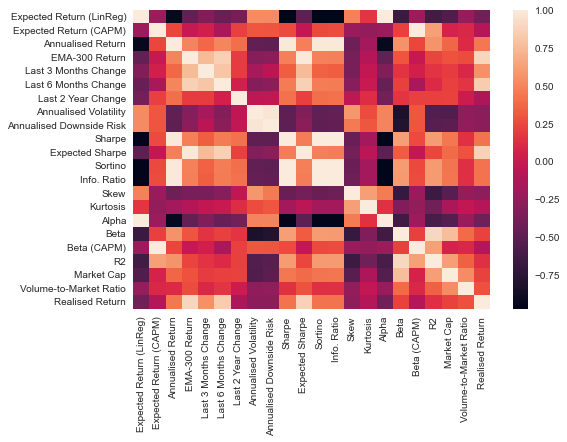

In [224]:
sns.heatmap(assets.corr())

In [225]:
corr=assets.corr()

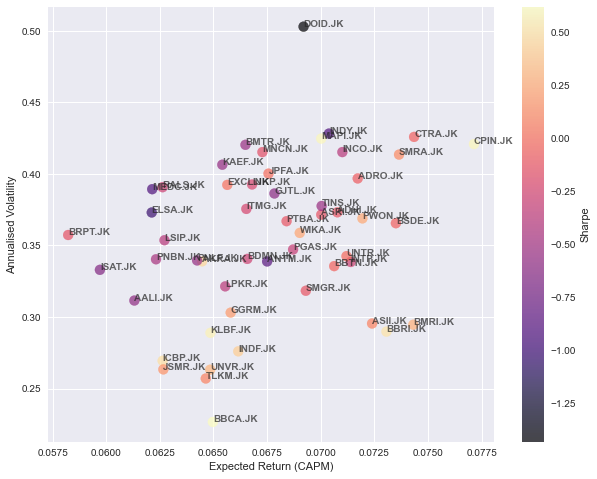

In [226]:
fig, ax = plt.subplots()
X = 'Expected Return (CAPM)'
Y = 'Annualised Volatility'
C = 'Sharpe'
ax= assets.plot.scatter(x=X, y=Y, c=C, 
                                           cmap= 'magma', marker='.', 
                                           s=400, alpha=0.7, grid=True, 
                                           figsize=[10,8], ax=ax)
label_point(assets[X], assets[Y], assets.index.to_series(), ax)

In [227]:
arr_scaled = scaler.fit_transform(assets)
assets_scaled = pd.DataFrame(arr_scaled, columns=assets.columns,index=assets.index)
assets_scaled = assets_scaled.sort_values(by='Annualised Volatility', ascending=False)
assets_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
DOID.JK,1.000000,0.580030,0.000000,0.358533,0.137278,0.000000,0.353257,1.000000,1.000000,0.000000,...,0.000000,0.714242,0.367871,1.000000,0.000000,0.580030,0.151330,0.000611,0.259366,0.173598
INDY.JK,0.880999,0.642563,0.332681,0.429125,0.307214,0.279542,0.144857,0.729556,0.692405,0.246662,...,0.245752,0.652958,0.276072,0.882480,0.141679,0.642563,0.338832,0.006411,0.105602,0.271165
CTRA.JK,0.526704,0.852404,0.709696,0.655683,0.521424,0.546048,0.436432,0.721108,0.630922,0.664041,...,0.670293,0.378190,0.036298,0.509960,0.216908,0.852404,0.492557,0.020031,0.124771,0.526447
MAPI.JK,0.205868,0.623526,1.000000,0.759438,0.571932,0.757101,0.643127,0.716818,0.630065,0.988136,...,1.000000,1.000000,1.000000,0.163581,0.146630,0.623526,0.332952,0.012448,0.153755,0.704574
CPIN.JK,0.130783,1.000000,0.997578,0.806086,1.000000,0.897176,0.916046,0.702973,0.700338,0.988039,...,0.999577,0.347425,0.176219,0.092072,0.276463,1.000000,0.607600,0.134021,0.069276,0.536371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICBP.JK,0.217435,0.232819,0.875111,0.748928,0.504398,0.747926,0.612864,0.154849,0.127989,0.935188,...,0.925567,0.331490,0.198799,0.199752,0.511799,0.232819,0.471824,0.121137,0.060505,0.656982
JSMR.JK,0.374319,0.234566,0.780706,0.612934,0.242920,0.448690,0.269697,0.133036,0.031962,0.770677,...,0.756872,0.434862,0.127060,0.369509,0.552025,0.234566,0.503189,0.033702,0.046707,0.609023
UNVR.JK,0.270247,0.349911,0.821013,0.655343,0.434963,0.590895,0.454152,0.132224,0.108865,0.843351,...,0.830778,0.318658,0.204532,0.265180,0.652175,0.349911,0.636072,0.191633,0.056326,0.542937
TLKM.JK,0.397009,0.339114,0.761765,0.682778,0.456215,0.609493,0.449124,0.110010,0.090711,0.737528,...,0.721717,0.000000,0.116613,0.402785,0.691426,0.339114,0.654721,0.408948,0.655918,0.601416


In [228]:
cor_target=abs(corr['Realised Return'])
relevant_features = cor_target[cor_target>0.4]
relevant_features

Expected Return (LinReg)    0.404728
Annualised Return           0.437845
EMA-300 Return              0.889586
Last 3 Months Change        0.551423
Last 6 Months Change        0.833049
Sharpe                      0.415254
Expected Sharpe             0.863064
Sortino                     0.420470
Info. Ratio                 0.413028
Alpha                       0.407440
Realised Return             1.000000
Name: Realised Return, dtype: float64

## **K-Means Clustering**

In [229]:
from sklearn.decomposition import PCA

def getPCA(df):
    pca = PCA(n_components=2)

    pComponents = pca.fit_transform(df)

    df_PCA = pd.DataFrame(data = pComponents, index=df.index,
                          columns = ['Principal Component 1', 'Principal Component 2'])
    return df_PCA

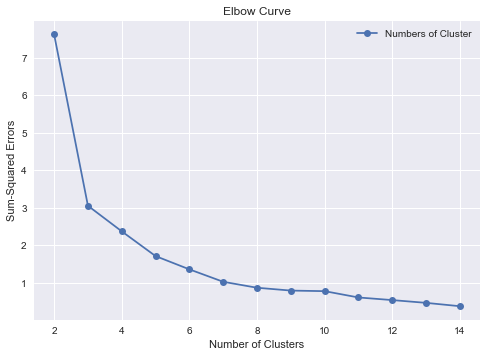

In [230]:
from sklearn.cluster import MiniBatchKMeans


unscaled_X = corr_matrix
scaled_X = scaler.fit_transform(unscaled_X)
scaled_X = pd.DataFrame(scaled_X, columns=unscaled_X.columns, index=unscaled_X.index)

cluster_vars = getPCA(scaled_X)

X = cluster_vars.values 

max_cluster = 15

sse_cluster = []

for k in range(2, max_cluster):
    kmeans =MiniBatchKMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse_cluster.append(kmeans.inertia_)
    
plt.plot(range(2, max_cluster), sse_cluster, marker ='o', label='Numbers of Cluster')
#plt.plot(5, 1.55, marker='v', c='r', ms=20, label='Ideal Cluster')
plt.title("Elbow Curve")
plt.xlabel('Number of Clusters')
plt.ylabel('Sum-Squared Errors')
plt.legend()
plt.show()

In [231]:
cluster_vars

,Principal Component 1,Principal Component 2
AALI.JK,-0.466505,0.175905
ADHI.JK,0.422724,-0.041156
ADRO.JK,-0.259818,0.697871
AKRA.JK,-0.108918,-0.226215
ANTM.JK,-0.140721,0.645030
...,...,...
TINS.JK,-0.094211,0.627295
TLKM.JK,0.210628,-0.112083
UNTR.JK,0.071989,0.431402
UNVR.JK,0.084297,-0.210795


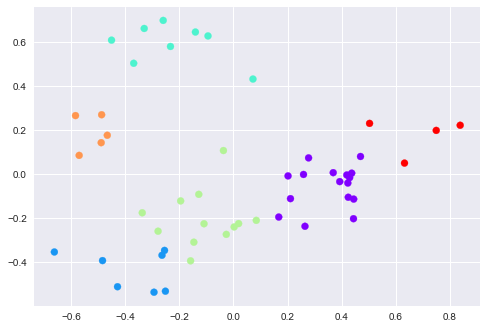

In [232]:
kmeans = MiniBatchKMeans(n_clusters=6, random_state=4567).fit(X)

centroids = kmeans.cluster_centers_

plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

In [233]:
cluster_labels = pd.DataFrame(kmeans.labels_, index= cluster_vars.index, columns=['Cluster Group'])
cluster_labels

,Cluster Group
AALI.JK,4
ADHI.JK,0
ADRO.JK,2
AKRA.JK,3
ANTM.JK,2
...,...
TINS.JK,2
TLKM.JK,0
UNTR.JK,2
UNVR.JK,3


In [234]:
assets_cluster = pd.concat([assets, cluster_labels], axis=1)

In [235]:
assets_cluster_scaled = pd.concat([assets_scaled, cluster_labels], axis=1)

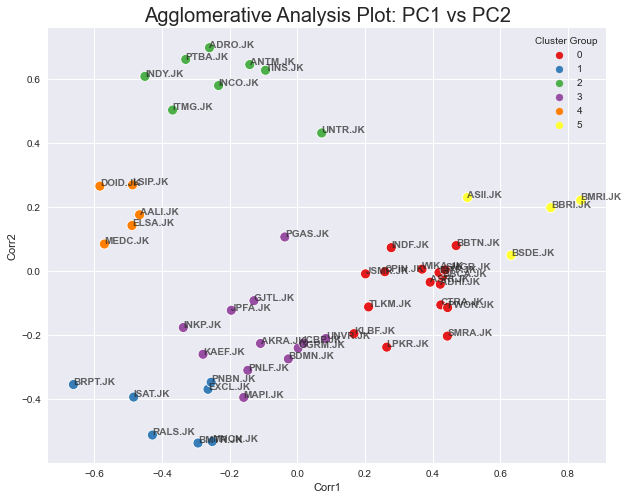

In [236]:
data_plot=cluster_vars.join(cluster_labels)

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=data_plot.iloc[:,0], y=data_plot.iloc[:,1], 
                data=data_plot, hue='Cluster Group', s=100,
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot: PC1 vs PC2', fontsize=20)
ax.set_xlabel('Corr1')
ax.set_ylabel('Corr2')
label_point(data_plot.iloc[:,0], data_plot.iloc[:,1],
             data_plot.index.to_series(), ax)

In [237]:
kmeans_mean = assets_cluster.groupby(['Cluster Group']).median()#.sort_values(by='Ann Returns', ascending=False)
kmeans_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.050917,0.069663,0.073093,-0.116582,-0.070426,-0.099762,-0.208262,0.337028,0.210762,0.094868,...,-0.003146,0.109695,0.857076,0.000070,0.274562,0.864740,0.475418,2.573500e+13,0.005501,0.009172
1,0.083201,0.062627,-0.074343,0.034782,-0.054394,0.014673,-0.515901,0.390707,0.229829,-0.300901,...,-0.379164,0.217335,0.990645,0.000185,0.167921,0.634623,0.345541,1.883000e+13,0.001923,0.230355
2,0.088155,0.070210,-0.088435,-0.360051,-0.147700,-0.380011,-0.043553,0.376570,0.233368,-0.329214,...,-0.406746,0.190966,0.745563,0.000210,0.219633,0.882636,0.434936,3.473000e+13,0.004531,-0.369382
3,0.072037,0.066188,-0.006642,-0.190196,-0.090332,-0.184948,-0.019966,0.343902,0.221498,-0.126827,...,-0.203975,0.186610,1.154982,0.000143,0.219546,0.751104,0.397044,2.334500e+13,0.002480,-0.083416
4,0.118153,0.062143,-0.321109,-0.210403,0.028573,-0.131769,-0.348137,0.373048,0.231386,-0.935813,...,-1.014355,0.271351,1.247228,0.000328,0.162075,0.618795,0.321165,7.370000e+12,0.008132,-0.145958
5,0.037878,0.073282,0.096023,0.066780,-0.006832,-0.133865,-0.072823,0.295085,0.190732,0.179077,...,0.075452,0.013336,0.686661,0.000029,0.412647,0.983083,0.628316,2.543650e+14,0.011051,0.037888


In [238]:
# actual_return = pd.DataFrame(columns= ['Actual Return (2020)'])
# for x in kmeans_mean.index:
#     sel = assets_cluster[assets_cluster['Cluster Group'] == x]
#     weights = np.ones(len(sel)) / len(sel)
#     actual_return.loc[x]=ret_2020[sel.index].dot(weights)

In [239]:
# kmeans_mean = kmeans_mean.join(actual_return)

In [240]:
kmeans_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.050917,0.069663,0.073093,-0.116582,-0.070426,-0.099762,-0.208262,0.337028,0.210762,0.094868,...,-0.003146,0.109695,0.857076,0.000070,0.274562,0.864740,0.475418,2.573500e+13,0.005501,0.009172
1,0.083201,0.062627,-0.074343,0.034782,-0.054394,0.014673,-0.515901,0.390707,0.229829,-0.300901,...,-0.379164,0.217335,0.990645,0.000185,0.167921,0.634623,0.345541,1.883000e+13,0.001923,0.230355
2,0.088155,0.070210,-0.088435,-0.360051,-0.147700,-0.380011,-0.043553,0.376570,0.233368,-0.329214,...,-0.406746,0.190966,0.745563,0.000210,0.219633,0.882636,0.434936,3.473000e+13,0.004531,-0.369382
3,0.072037,0.066188,-0.006642,-0.190196,-0.090332,-0.184948,-0.019966,0.343902,0.221498,-0.126827,...,-0.203975,0.186610,1.154982,0.000143,0.219546,0.751104,0.397044,2.334500e+13,0.002480,-0.083416
4,0.118153,0.062143,-0.321109,-0.210403,0.028573,-0.131769,-0.348137,0.373048,0.231386,-0.935813,...,-1.014355,0.271351,1.247228,0.000328,0.162075,0.618795,0.321165,7.370000e+12,0.008132,-0.145958
5,0.037878,0.073282,0.096023,0.066780,-0.006832,-0.133865,-0.072823,0.295085,0.190732,0.179077,...,0.075452,0.013336,0.686661,0.000029,0.412647,0.983083,0.628316,2.543650e+14,0.011051,0.037888


In [241]:
kmeans_scaled = scaler.fit_transform(kmeans_mean)
kmeans_mean_scaled = pd.DataFrame(kmeans_scaled, columns=assets.columns,index=kmeans_mean.index)

In [242]:
kmeans_mean_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.162423,0.675139,0.945029,0.570410,0.438377,0.710059,0.620322,0.438632,0.469785,0.924468,...,0.927879,0.373463,0.304005,0.136770,0.448921,0.675139,0.502204,0.074354,0.392027,0.631200
1,0.564591,0.043448,0.591577,0.925033,0.529326,1.000000,0.000000,1.000000,0.917007,0.569484,...,0.582847,0.790651,0.542280,0.523657,0.023331,0.043448,0.079361,0.046398,0.000000,1.000000
2,0.626300,0.724263,0.557795,0.000000,0.000000,0.000000,0.952439,0.852158,1.000000,0.544089,...,0.557538,0.688448,0.105075,0.607100,0.229705,0.724263,0.370406,0.110771,0.285653,0.000000
3,0.425521,0.363198,0.753879,0.397943,0.325450,0.494227,1.000000,0.510520,0.721589,0.725619,...,0.743600,0.671567,0.835441,0.382152,0.229361,0.363198,0.247042,0.064677,0.061031,0.476819
4,1.000000,0.000000,0.000000,0.350602,1.000000,0.628964,0.338279,0.815321,0.953511,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.680256,0.372536
5,0.000000,1.000000,1.000000,1.000000,0.799144,0.623654,0.893420,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.679081


<AxesSubplot:xlabel='Cluster Group'>

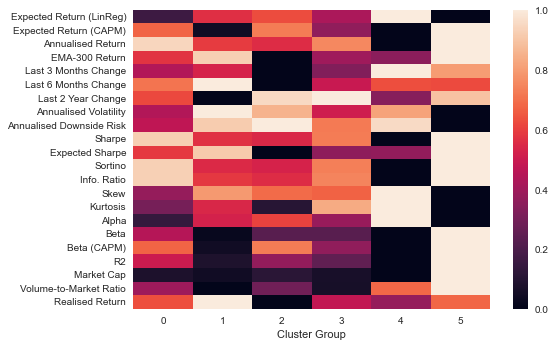

In [243]:
sns.heatmap(kmeans_mean_scaled.T)

In [244]:
cluster_method= assets_cluster
cluster_mean = kmeans_mean

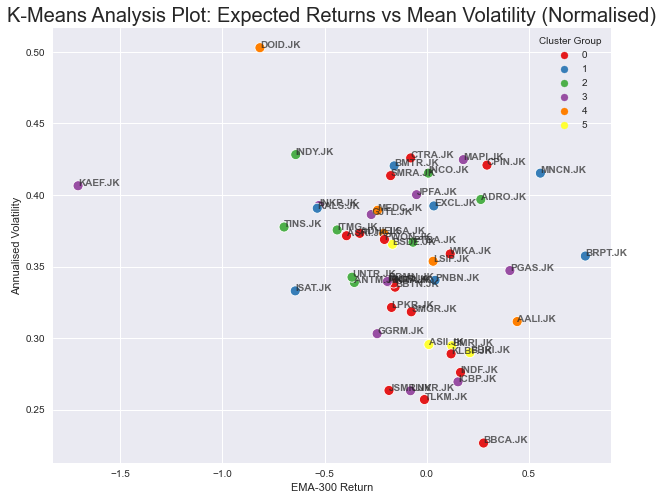

In [245]:
data_plot=assets_cluster
X='EMA-300 Return'
Y='Annualised Volatility'

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, 
                hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('K-Means Analysis Plot: Expected Returns vs Mean Volatility (Normalised)', fontsize=20)
label_point(data_plot[X], data_plot[Y],
            data_plot.index.to_series(), ax)

In [246]:
cluster_method= assets_cluster
cluster_mean = kmeans_mean
picking_param = 'Sharpe'
kmeans_portfolio=pd.DataFrame()
# for cluster in cluster_mean.index:
#     kmeans_portfolio=kmeans_portfolio.append(cluster_method[cluster_method['Cluster Group']==cluster].sort_values(by=picking_param, ascending=False).iloc[0])

In [247]:
kmeans_portfolio = cluster_method[cluster_method['Cluster Group']==cluster_mean[picking_param].idxmax()]

## **PCA Clustering**

In [192]:
from sklearn.cluster import AgglomerativeClustering

assets_PCA = getPCA(dist_matrix)
assets_PCA

,Principal Component 1,Principal Component 2
AALI.JK,0.472378,-0.017930
ADHI.JK,-0.383427,-0.084773
ADRO.JK,0.496100,-0.521601
AKRA.JK,0.006869,0.227992
ANTM.JK,0.381625,-0.499794
...,...,...
TINS.JK,0.331582,-0.496799
TLKM.JK,-0.233112,0.001822
UNTR.JK,0.102707,-0.382978
UNVR.JK,-0.153362,0.139634


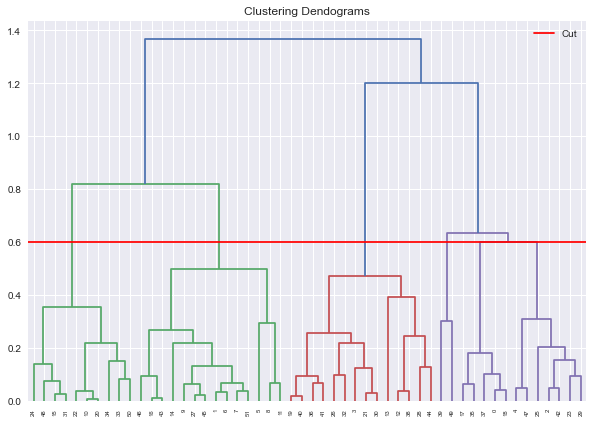

In [193]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(10, 7))  
plt.title('Clustering Dendograms')
plt.axhline(y=.6, color='r', linestyle='-', label='Cut')
plt.legend()
dend = dendrogram(linkage(assets_PCA, method='complete'))

In [194]:
# cluster_vars = assets_PCA

# X = cluster_vars.values 

# max_cluster = 10

# sse = []

# for k in range(2, max_cluster):
#     agg =AgglomerativeClustering(n_clusters = k)
#     agg.fit(X)
    
#     sse.append(agg.inertia_)
    
# plt.plot(range(2, max_cluster), sse, marker ='s')
# plt.title("Elbow Curve")
# plt.show()

In [195]:
X_pca = assets_PCA.values

In [196]:
agg_pca = AgglomerativeClustering(n_clusters=7, linkage='complete').fit(X_pca)

In [197]:
cluster_labels_pca = pd.DataFrame(agg_pca.labels_, index= assets_PCA.index, columns=['Cluster Group'])
assets_scaled_cluster_pca = pd.concat([assets_scaled, cluster_labels_pca], axis=1)
assets_scaled_cluster_pca #.sort_values(by='Annualised Returns', ascending=False).head(10)

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Cluster Group
DOID.JK,1.000000,0.580030,0.000000,0.358533,0.137278,0.000000,0.353257,1.000000,0.932700,1.000000,...,0.714242,0.367871,1.000000,0.000000,0.580030,0.151330,0.000611,0.259366,0.173598,5
INDY.JK,0.880999,0.642563,0.332681,0.429125,0.307214,0.279542,0.144857,0.729556,0.817094,0.692405,...,0.652958,0.276072,0.882480,0.141679,0.642563,0.338832,0.006411,0.105602,0.271165,3
CTRA.JK,0.526704,0.852404,0.709696,0.655683,0.521424,0.546048,0.436432,0.721108,0.755612,0.630922,...,0.378190,0.036298,0.509960,0.216908,0.852404,0.492557,0.020031,0.124771,0.526447,6
MAPI.JK,0.205868,0.623526,1.000000,0.759438,0.571932,0.757101,0.643127,0.716818,0.672031,0.630065,...,1.000000,1.000000,0.163581,0.146630,0.623526,0.332952,0.012448,0.153755,0.704574,0
CPIN.JK,0.130783,1.000000,0.997578,0.806086,1.000000,0.897176,0.916046,0.702973,0.915961,0.700338,...,0.347425,0.176219,0.092072,0.276463,1.000000,0.607600,0.134021,0.069276,0.536371,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICBP.JK,0.217435,0.232819,0.875111,0.748928,0.504398,0.747926,0.612864,0.154849,0.134523,0.127989,...,0.331490,0.198799,0.199752,0.511799,0.232819,0.471824,0.121137,0.060505,0.656982,1
JSMR.JK,0.374319,0.234566,0.780706,0.612934,0.242920,0.448690,0.269697,0.133036,0.442536,0.031962,...,0.434862,0.127060,0.369509,0.552025,0.234566,0.503189,0.033702,0.046707,0.609023,1
UNVR.JK,0.270247,0.349911,0.821013,0.655343,0.434963,0.590895,0.454152,0.132224,0.185703,0.108865,...,0.318658,0.204532,0.265180,0.652175,0.349911,0.636072,0.191633,0.056326,0.542937,1
TLKM.JK,0.397009,0.339114,0.761765,0.682778,0.456215,0.609493,0.449124,0.110010,0.222766,0.090711,...,0.000000,0.116613,0.402785,0.691426,0.339114,0.654721,0.408948,0.655918,0.601416,1


In [198]:
assets_cluster_pca = pd.concat([assets, cluster_labels_pca], axis=1)
assets_cluster_pca

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Cluster Group
AALI.JK,0.103612,0.061312,-0.145728,0.442900,0.224662,0.260085,-0.304223,0.311554,0.285881,0.210540,...,-0.006626,1.024341,0.000276,0.222644,0.591624,0.362372,1.636000e+13,0.000367,0.297488,5
ADHI.JK,0.071826,0.070774,-0.005194,-0.327584,-0.216611,-0.449445,-0.243048,0.373173,0.315725,0.224174,...,0.267908,1.067771,0.000148,0.236501,0.901060,0.460619,2.920000e+12,0.004496,-0.273038,6
ADRO.JK,0.072057,0.071722,0.003357,0.264974,-0.047628,-0.100471,0.000839,0.396814,0.409746,0.248012,...,0.073979,0.700447,0.000147,0.216012,0.932086,0.447246,4.318000e+13,0.014482,0.172363,3
AKRA.JK,0.028059,0.064470,0.195625,-0.189718,-0.111226,-0.169225,-0.391959,0.338924,0.313855,0.202682,...,0.197387,0.595228,-0.000032,0.221116,0.694903,0.391324,1.476000e+13,0.002645,-0.092504,0
ANTM.JK,0.136095,0.067500,-0.259027,-0.354422,-0.262364,-0.322809,-0.151434,0.338843,0.371948,0.204808,...,0.260026,1.075841,0.000412,0.252717,0.793994,0.447173,6.224000e+13,0.012936,-0.190808,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.109459,0.070040,-0.166994,-0.698260,-0.242115,-0.710806,-0.087946,0.377597,0.402781,0.216658,...,0.380023,0.928502,0.000301,0.224402,0.877070,0.442276,1.143000e+13,0.005016,-0.730165,3
TLKM.JK,0.049851,0.064640,0.063873,-0.011183,-0.092299,-0.052056,-0.146550,0.257104,0.238196,0.169750,...,-0.108945,0.697553,0.000075,0.388652,0.700478,0.521130,3.298800e+14,0.024880,0.070687,1
UNTR.JK,0.062571,0.071200,0.033452,-0.365680,-0.044635,-0.441695,-0.158581,0.342552,0.322260,0.219029,...,0.015970,0.450074,0.000116,0.285001,0.914988,0.509489,7.917000e+13,0.001128,-0.352360,4
UNVR.JK,0.028583,0.064845,0.121556,-0.079321,-0.106556,-0.073766,-0.135884,0.263238,0.226025,0.172561,...,0.081952,0.946078,-0.000013,0.373533,0.707158,0.513722,1.556500e+14,0.002402,-0.049780,1


<AxesSubplot:>

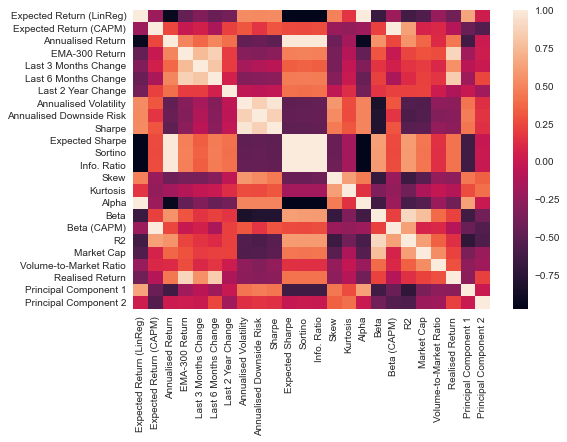

In [199]:
sns.heatmap(assets_scaled_cluster_pca.drop('Cluster Group',axis=1).join(assets_PCA).corr())

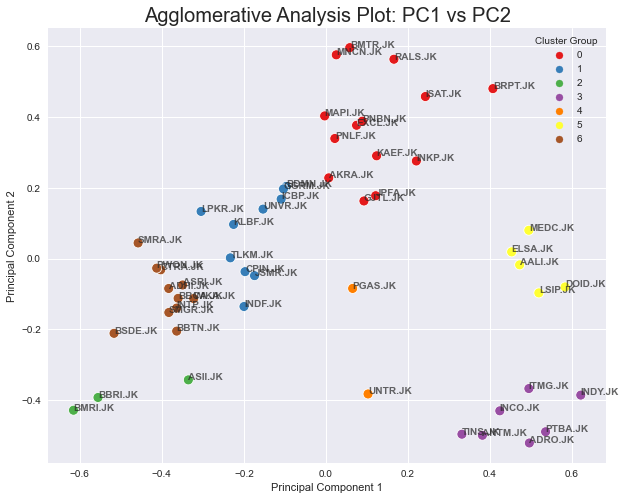

In [200]:
data_plot=assets_PCA.join(cluster_labels_pca)

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x='Principal Component 1', y='Principal Component 2', 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot: PC1 vs PC2', fontsize=20)
label_point(data_plot['Principal Component 1'], data_plot['Principal Component 2'],
            data_plot.index.to_series(), ax)

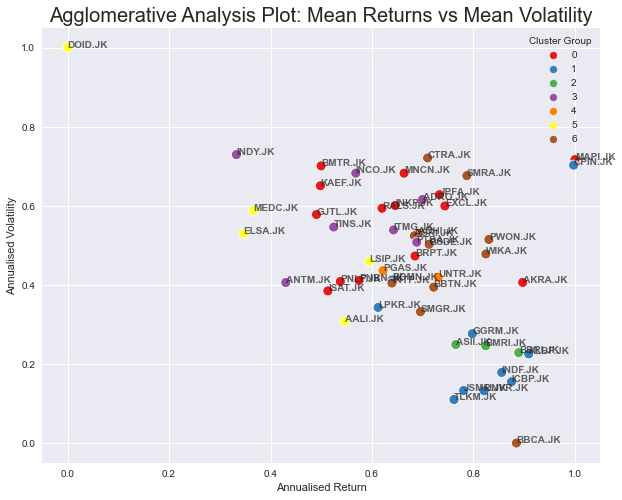

In [201]:
data_plot=assets_scaled_cluster_pca
X= 'Annualised Return'
Y= 'Annualised Volatility'

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot: Mean Returns vs Mean Volatility', fontsize=20)
label_point(data_plot[X], data_plot[Y],
            data_plot.index.to_series(), ax)

In [202]:
cluster_pca_mean = assets_cluster_pca.groupby(['Cluster Group']).median() #.sort_values(by='Alpha', ascending=False)
cluster_pca_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.081204,0.065527,-0.061731,-0.174587,-0.064251,-0.159465,-0.228652,0.391514,0.386687,0.236198,...,-0.346125,0.227941,1.166897,0.000179,0.177495,0.729462,0.361380,1.388000e+13,0.002445,-0.046118
1,0.037314,0.065202,0.110285,-0.045252,-0.093059,-0.048768,-0.060953,0.282529,0.272945,0.178892,...,0.132305,0.103145,0.897959,0.000020,0.314542,0.718858,0.465934,6.634000e+13,0.002723,0.022462
2,0.024684,0.073062,0.124663,0.122796,-0.006356,-0.127501,-0.042046,0.294666,0.260472,0.189648,...,0.172615,0.002915,0.745646,-0.000023,0.425206,0.975899,0.641504,2.891100e+14,0.013429,0.075776
3,0.095500,0.070040,-0.124648,-0.354422,-0.157004,-0.322809,0.000839,0.377597,0.402781,0.236326,...,-0.477924,0.247456,0.790678,0.000240,0.216012,0.877070,0.427595,2.628000e+13,0.004812,-0.386404
4,0.076242,0.069955,-0.019531,0.020797,0.078851,-0.122054,-0.209906,0.344862,0.341119,0.219057,...,-0.269614,0.059546,0.639072,0.000170,0.268977,0.874273,0.483839,5.237000e+13,0.005787,-0.005664
5,0.118153,0.062143,-0.321109,-0.210403,0.028573,-0.131769,-0.348137,0.373048,0.364881,0.231386,...,-1.014355,0.271351,1.247228,0.000328,0.162075,0.618795,0.321165,7.370000e+12,0.008132,-0.145958
6,0.067556,0.070774,0.016039,-0.161449,-0.103919,-0.175069,-0.271556,0.365553,0.339827,0.222228,...,-0.145890,0.102506,0.760921,0.000135,0.252720,0.901060,0.485574,1.807000e+13,0.005680,-0.074245


In [203]:
pca_scaled = scaler.fit_transform(cluster_pca_mean)
pca_mean_scaled = pd.DataFrame(pca_scaled, columns=assets.columns,index=cluster_pca_mean.index)

In [204]:
pca_mean_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.604693,0.309902,0.581862,0.376839,0.393263,0.596058,0.342387,1.000000,0.886913,0.997771,...,0.562972,0.838288,0.867910,0.576174,0.058604,0.309902,0.125537,0.023106,0.000000,0.736262
1,0.135121,0.280207,0.967746,0.647859,0.271121,1.000000,0.822931,0.000000,0.087647,0.000000,...,0.966040,0.373385,0.425692,0.123762,0.579432,0.280207,0.451926,0.209306,0.025344,0.884646
2,0.000000,1.000000,1.000000,1.000000,0.638730,0.712697,0.877111,0.111364,0.000000,0.187279,...,1.000000,0.000000,0.175240,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.757641,0.723248,0.440721,0.000000,0.000000,0.000000,1.000000,0.872306,1.000000,1.000000,...,0.451933,0.910987,0.249288,0.750243,0.204983,0.723248,0.332243,0.067119,0.215519,0.000000
4,0.551609,0.715417,0.676529,0.786263,1.000000,0.732572,0.396102,0.571944,0.566706,0.699318,...,0.627430,0.210966,0.000000,0.550037,0.406268,0.715417,0.507820,0.159722,0.304271,0.823790
5,1.000000,0.000000,0.000000,0.301788,0.786829,0.697121,0.000000,0.830564,0.733679,0.913983,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.517822,0.520242
6,0.458674,0.790428,0.756323,0.404369,0.225076,0.539116,0.219443,0.761798,0.557629,0.754530,...,0.731666,0.371007,0.200357,0.449908,0.344487,0.790428,0.513235,0.037978,0.294580,0.675406


In [205]:
assets_scaled_cluster_pca.groupby(['Cluster Group']).var()

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.028868,0.029783,0.023813,0.056114,0.046420,0.062751,0.065783,0.014148,0.027025,2.075037e-02,...,0.038450,0.034326,0.051842,0.032638,0.003738,0.029783,0.010052,0.000892,0.016531,0.081507
1,0.030675,0.047091,0.013641,0.005683,0.050206,0.023038,0.039840,0.033331,0.048831,4.164515e-02,...,0.027906,0.015546,0.005247,0.033941,0.020675,0.047091,0.007782,0.013631,0.070555,0.005023
2,0.028432,0.002657,0.003851,0.001642,0.000035,0.001226,0.001773,0.000122,0.000601,6.814196e-04,...,0.010660,0.003362,0.001278,0.031531,0.001643,0.002657,0.003000,0.024542,0.173463,0.005302
3,0.025302,0.010326,0.018740,0.020570,0.029766,0.033225,0.047070,0.012054,0.007922,1.606412e-02,...,0.028392,0.033116,0.006302,0.028890,0.004235,0.010326,0.003782,0.000688,0.019389,0.025199
4,0.013278,0.008663,0.005923,0.048427,0.067766,0.149960,0.001171,0.000140,0.006597,6.169572e-08,...,0.011328,0.010582,0.008941,0.014141,0.003461,0.008663,0.008338,0.002235,0.030882,0.056649
5,0.019870,0.029071,0.054829,0.034049,0.094996,0.110822,0.017108,0.066952,0.045031,6.979297e-02,...,0.036889,0.047581,0.020263,0.021046,0.009800,0.029071,0.003669,0.000060,0.013558,0.037380
6,0.029536,0.019463,0.005805,0.005690,0.022052,0.014700,0.013562,0.036461,0.045736,2.761914e-02,...,0.014790,0.038334,0.006596,0.030053,0.046712,0.019463,0.012843,0.087262,0.026713,0.008273


In [206]:
# actual_return = pd.DataFrame(columns= ['Actual Return (2020)'])
# for x in cluster_pca_mean.index:
#     sel = assets_scaled_cluster_pca[assets_scaled_cluster_pca['Cluster Group'] == x]
#     weights = np.ones(len(sel)) / len(sel)
#     actual_return.loc[x]=ret_2020[sel.index].dot(weights)

In [207]:
# actual_return_sort=actual_return.sort_values(by='Actual Return (2020)', ascending=False)
# actual_return_sort

In [208]:
pca_cluster_mean = pca_mean_scaled#.join(actual_return)#.sort_values(by='Alpha', ascending=False)
pca_cluster_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Info. Ratio,Skew,Kurtosis,Alpha,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.604693,0.309902,0.581862,0.376839,0.393263,0.596058,0.342387,1.000000,0.886913,0.997771,...,0.562972,0.838288,0.867910,0.576174,0.058604,0.309902,0.125537,0.023106,0.000000,0.736262
1,0.135121,0.280207,0.967746,0.647859,0.271121,1.000000,0.822931,0.000000,0.087647,0.000000,...,0.966040,0.373385,0.425692,0.123762,0.579432,0.280207,0.451926,0.209306,0.025344,0.884646
2,0.000000,1.000000,1.000000,1.000000,0.638730,0.712697,0.877111,0.111364,0.000000,0.187279,...,1.000000,0.000000,0.175240,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.757641,0.723248,0.440721,0.000000,0.000000,0.000000,1.000000,0.872306,1.000000,1.000000,...,0.451933,0.910987,0.249288,0.750243,0.204983,0.723248,0.332243,0.067119,0.215519,0.000000
4,0.551609,0.715417,0.676529,0.786263,1.000000,0.732572,0.396102,0.571944,0.566706,0.699318,...,0.627430,0.210966,0.000000,0.550037,0.406268,0.715417,0.507820,0.159722,0.304271,0.823790
5,1.000000,0.000000,0.000000,0.301788,0.786829,0.697121,0.000000,0.830564,0.733679,0.913983,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.517822,0.520242
6,0.458674,0.790428,0.756323,0.404369,0.225076,0.539116,0.219443,0.761798,0.557629,0.754530,...,0.731666,0.371007,0.200357,0.449908,0.344487,0.790428,0.513235,0.037978,0.294580,0.675406


<AxesSubplot:xlabel='Cluster Group'>

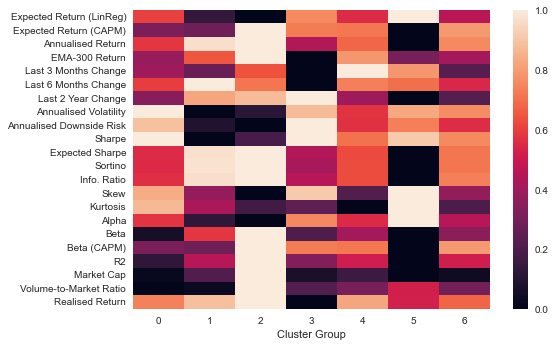

In [209]:
sns.heatmap(pca_cluster_mean.T)

<AxesSubplot:>

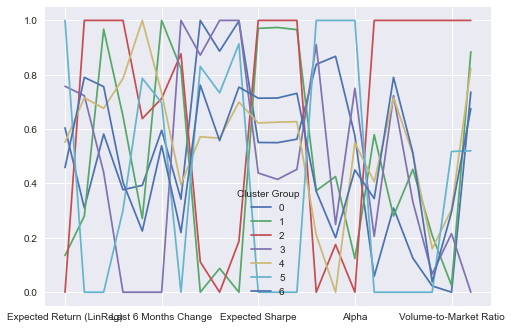

In [210]:
pca_cluster_mean.T.plot()

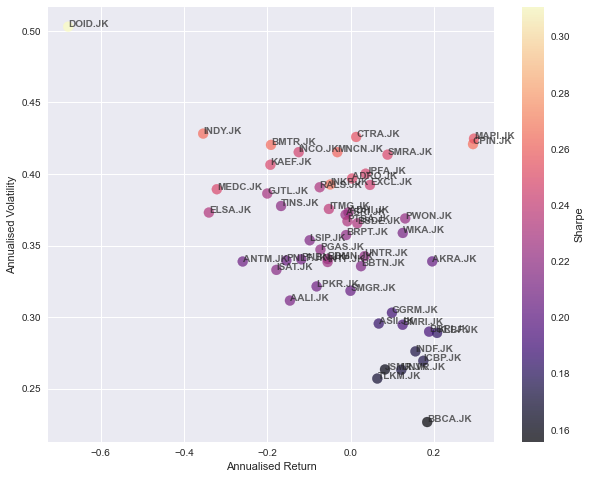

In [211]:
fig, ax = plt.subplots()
data_plot = assets_cluster_pca
X = 'Annualised Return'
Y = 'Annualised Volatility'
C = 'Sharpe'
ax= data_plot.plot.scatter(x=X, y=Y, c=C, 
                                           cmap= 'magma', marker='.', 
                                           s=400, alpha=0.7, grid=True, 
                                           figsize=[10,8], ax=ax)
label_point(data_plot[X], data_plot[Y], assets.index.to_series(), ax)

In [212]:
cluster_method= assets_cluster_pca
cluster_mean = pca_cluster_mean
picking_param = 'Sharpe'
pca_portfolio=pd.DataFrame()
# for cluster in cluster_mean.index:
#     pca_portfolio=pca_portfolio.append(cluster_method[cluster_method['Cluster Group']==cluster].sort_values(by=picking_param, ascending=False).iloc[0])

In [213]:
pca_portfolio=cluster_method[cluster_method['Cluster Group']==cluster_mean[picking_param].idxmax()]

# **Hierchical Risk Parity**

In [214]:
import scipy.cluster.hierarchy as sch

class HRPRes:
    def __init__(self, cov, corr, dist, link):
        self.cov = cov
        self.corr = corr
        self.dist = dist
        self.link = link

def HRP(assets_returns):
    rets = assets_returns

    ewm_cov = rets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]

    ewm_corr = rets.ewm(span=300).corr()
    corr = ewm_corr.loc[ewm_corr.index.levels[0][-1]]

    dist=((1-corr)/2.)**.5

    link=sch.linkage(dist, 'single')
    
    return HRPRes(cov=cov, corr=corr, dist=dist, link=link)

In [215]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [216]:
def getHRP(assets_rets):
    HRPres = HRP(assets_rets)
    sortIx=getQuasiDiag(HRPres.link)
    sortIx = HRPres.corr.index[sortIx].tolist()
    return getRecBipart(HRPres.cov, sortIx)

In [217]:
rand_assets = assets.sample(n=5)
rand_rets = ret[rand_assets.index]
getHRP(rand_rets)

/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_17670/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


BRPT.JK    0.183386
JPFA.JK    0.197358
JSMR.JK    0.254408
GJTL.JK    0.216945
EXCL.JK    0.147903
dtype: float64

# **Markowitz Optimisation**

In [218]:
rng = np.random.default_rng(seed=4567)

class ReturnRes:
    def __init__(self, port, weights):
        self.port = port
        self.weights = weights
        
def monte_carlo_optimise (_assets, num_port):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.ewm(span=300).mean().iloc[-1]
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    semicov = ret_assets[ret_assets < 0].cov()
    num_assets = len(assets_sel.index)
    num_portfolios = num_port
    beta_assets = assets_sel['Beta']
    alpha_assets = assets_sel['Alpha']
    rand_weights = rng.random(size=(num_portfolios, num_assets)).round(2)
    _weights = pd.DataFrame((rand_weights.T / rand_weights.sum(axis=1)).T, columns=assets_sel.index)
    p_ret =mean_ret.dot(_weights.T)*252
    p_real_ret = _weights.dot(_real_ret)
    p_exp_ret = _weights.dot(exp_ret_assets)
    p_vol =_weights.apply(lambda row: np.sqrt(row.T@cov@row), axis=1)
    p_dsrisk =_weights.apply(lambda row: row.dot(semicov.dot(row.T))**0.5, axis=1)
    p_premium =p_ret - rf_rate
    p_sharpe =p_premium / (p_vol*np.sqrt(252))
    p_sortino =p_premium / (p_dsrisk*np.sqrt(252))
    p_beta =_weights.dot(beta_assets)
    p_alpha =_weights.dot(alpha_assets)
    p_weights = _weights.copy()
    p_weights.columns = pd.MultiIndex.from_product([_weights, ['Weights']])
    port_metrics = pd.DataFrame({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 'Volatility':p_vol, 
                                    'Downside Risk' : p_dsrisk, 'Market Risk Premium':p_premium, 
                                    'Sharpe' :p_sharpe, 'Sortino': p_sortino, 'Weighted Alpha': p_alpha,
                                    'Weighted Beta':p_beta})
    portfolios = port_metrics.copy()
    portfolios[p_weights.columns]  = p_weights
    
    return ReturnRes(port=portfolios, weights=_weights)

def equal_weights_port (_assets):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.ewm(span=300).mean().iloc[-1]
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    semicov = ret_assets[ret_assets < 0].cov()
    num_assets = len(assets_sel.index)
    beta_assets = assets_sel['Beta']
    alpha_assets = assets_sel['Alpha']
    test_weights_equal = np.ones(num_assets).round(2)*(1/num_assets)
    _weights = pd.Series(test_weights_equal, index=assets_sel.index)
    p_ret =mean_ret.dot(_weights)*252
    p_real_ret = _real_ret.dot(_weights)
    p_exp_ret = exp_ret_assets.dot(_weights)
    p_vol =_weights.T.dot(cov.dot(_weights))**0.5
    p_dsrisk =_weights.T.dot(semicov.dot(_weights))**0.5
    p_premium =p_ret - rf_rate
    p_sharpe =p_premium / (p_vol*np.sqrt(252))
    p_sortino =p_premium / (p_dsrisk*np.sqrt(252))
    p_beta =_weights.T.dot(beta_assets)
    p_alpha =_weights.T.dot(alpha_assets)
    #p_weights = _weights.copy()
    port_metrics = pd.Series({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 'Volatility':p_vol, 
                                    'Downside Risk' : p_dsrisk, 'Market Risk Premium':p_premium, 
                                    'Sharpe' :p_sharpe, 'Sortino': p_sortino, 'Weighted Alpha': p_alpha,
                                    'Weighted Beta':p_beta, 'Stocks':'Weights'})
    portfolios = port_metrics.copy()
    #portfolios=portfolios.append(_weights)
    
    return ReturnRes(port=portfolios, weights=_weights)


def HRP_port (_assets):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.ewm(span=300).mean().iloc[-1]
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]*252.
    semicov = ret_assets[ret_assets < 0].cov()*252.
    num_assets = len(assets_sel.index)
    beta_assets = assets_sel['Beta']
    alpha_assets = assets_sel['Alpha']
    _weights = getHRP(ret_assets)
    p_ret =mean_ret.dot(_weights)*252
    p_real_ret = _real_ret.dot(_weights)
    p_exp_ret = exp_ret_assets.dot(_weights)
    p_vol =_weights.T.dot((cov).dot(_weights))**0.5
    p_dsrisk =_weights.T.dot((semicov).dot(_weights))**0.5
    p_premium =p_ret - rf_rate
    p_sharpe =p_premium / (p_vol)
    p_sortino =p_premium / (p_dsrisk)
    p_beta =_weights.T.dot(beta_assets)
    p_alpha =_weights.T.dot(alpha_assets)
    #p_weights = _weights.copy()
    port_metrics = pd.Series({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 'Volatility':p_vol, 
                                    'Downside Risk' : p_dsrisk, 'Market Risk Premium':p_premium, 
                                    'Sharpe' :p_sharpe, 'Sortino': p_sortino, 'Weighted Alpha': p_alpha,
                                    'Weighted Beta':p_beta, 'Stocks':'Weights'})
    portfolios = port_metrics.copy()
    #portfolios=portfolios.append(_weights)
    
    return ReturnRes(port=portfolios, weights=_weights)

def min_volatility(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx=port['Volatility'].idxmin()
    return ReturnRes(port=port.iloc[idx], 
                     weights=w.iloc[idx])

def optimal_risk(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx = port['Sharpe'].idxmax()
    return ReturnRes(port=port.iloc[idx], 
                     weights=w.iloc[idx])

def high_alpha(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx = port['Weighted Alpha'].idxmax()
    return ReturnRes(port=port.iloc[idx], 
                        weights=w.loc[idx])

def plot_summarise(portfolios, Y ='Expected Return', X = 'Volatility', plot_opt=True, plot_min=False, plot_alpha=False):
    portfolio = portfolios.port
    plt.subplots(figsize=(10, 8))
    plt.scatter(portfolio[X], portfolio[Y], c= portfolio['Sharpe'],cmap='magma', marker='.', s=10, alpha=0.3)
    plt.colorbar().set_label('Sharpe')
    plt.xlabel(X)
    plt.ylabel(Y)
    
    if plot_opt==True:
        optimal_risky_port=optimal_risk(portfolios).port
        plt.scatter(optimal_risky_port[X], optimal_risky_port[Y], color='g', marker='^', s=200, label = 'Optimal Risky Portfolio - Maximum Sharpe Ratio')
    if plot_min==True:
        min_vol_port =min_volatility(portfolios).port
        plt.scatter(min_vol_port[X], min_vol_port[Y], color='r', marker='^', s=200, label= 'Minimum Volatility Portfolio')
    if plot_alpha==True:
        high_alpha_port = high_alpha(portfolios).port
        plt.scatter(high_alpha_port[X], high_alpha_port[Y], color='b', marker='^', s=200, label = 'High Alpha - Maximum Alpha')
    else:
        pass
    
    plt.legend(labelspacing=0.8, loc='lower left')
    plt.show()
    
def print_port(portfolios):
    portfolio = portfolios.port
    min_vol_port =min_volatility(portfolios).port
    optimal_risky_port=optimal_risk(portfolios).port
    high_alpha_port = high_alpha(portfolios).port
    print('-'*10)
    print('Optimally Risky Portfolio')
    print('-'*10)
    print(optimal_risky_port)
    print('-'*10)
    print('-'*10)
    print('Minimal Risk Portfolio')
    print('-'*10)
    print(min_vol_port)
    print('-'*10)
    print('-'*10)
    print('High Alpha Portfolio')
    print('-'*10)
    print(high_alpha_port)
    print('-'*10)

In [219]:
rand_assets = assets.sort_values(by='EMA-300 Return', ascending=False).head(10).sample(n=3)
num_port=5000

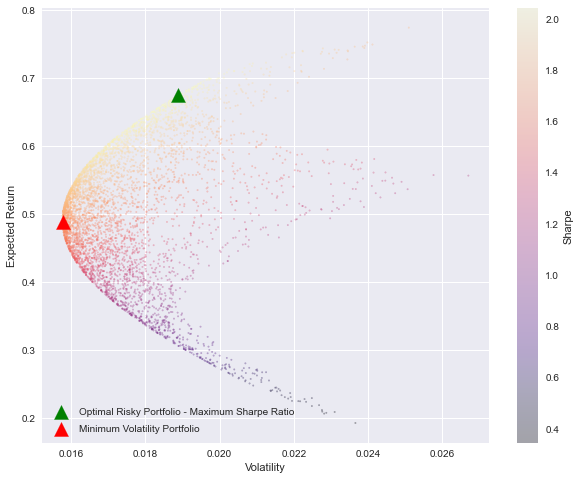

In [220]:
ran_port = monte_carlo_optimise(rand_assets,num_port=num_port)
ran_port.port
plot_summarise(ran_port, plot_min=True)

# **Testing 2019**

In [221]:
from scipy.stats import norm

def backtest(portfolios, plots=False, test_year = test_year, end_year=end_year, num_port=500000, initial_inv=1000000000, weights_equal=False, HRP=False):
    pd.options.display.max_rows = None
     
    if weights_equal==True:
        _port = equal_weights_port(portfolios)
        test_weights=_port.weights.values
        _weights=test_weights
    elif HRP==True:
        _port = HRP_port(portfolios)
        test_weights=_port.weights.values
        _weights=test_weights    
    else:
        rand_portfolios = monte_carlo_optimise(portfolios, num_port)
        optimal_risk_port = optimal_risk(rand_portfolios)
        _port = optimal_risk_port
        test_weights = _port.weights.values
        _weights = test_weights
        plot_summarise(rand_portfolios,plot_min=True)
        
    display(_port.port)
    display(_port.weights)
    _port_assets = portfolios
    _num_assets = len(_port_assets)
    test_yr = test_year #Training year + 1 year
    end_yr = end_year
    
    # Get price data
    port_close_price = close_price_all[_port_assets.index]
    test_close=port_close_price[test_yr:end_yr]
    test_ret = (test_close.iloc[-1] / test_close.iloc[0]) - 1
    test_ret_pct = test_ret
    ret_port_asset=log_rate(port_close_price).dropna()
    
    # Get market price data
    market_test = market_data_all['Close'][test_year:end_year]
    market_hold_ret = (market_test.iloc[-1] / market_test[0]) -1 
    market_cum_log_ret = log_rate(market_test).cumsum().ffill()
    market_log_ret = log_rate(market_test).sum()
    
    # Get unweighted mean and cov
    mean_ret_port=ret_port_asset.mean()
    cov_ret_port =ret_port_asset.cov()
    semicov_ret_port = ret_port_asset[ret_port_asset < 0].cov()
    
    # Calculate returns
    holding_ret_port = test_ret_pct.dot(_weights)
    log_rets = log_rate(test_close).dot(_weights)
    port_cum = log_rets.sum()
    log_rets_cum = log_rets.cumsum().ffill()
    max_drawdown = log_rets_cum.min()
    
    # Get monthly and yearly returns
    mon_rets = log_rets.resample('M').sum()
    quarter_rets = log_rets.resample('Q').sum()
    quarter_rets.index = quarter_rets.index.strftime('%m/%Y')
    mon_rets.index = mon_rets.index.strftime('%m/%Y')
    
    # Get weighted mean and cov
    mean_port = mean_ret_port.dot(_weights)
    stdev_port = np.sqrt(_weights.T.dot(cov_ret_port.dot(_weights))*252)
    semistdev_port = np.sqrt(_weights.T.dot(semicov_ret_port.dot(_weights))*252)
    
    # Calculate statitics
    volatility = stdev_port
    downside_risk = semistdev_port
    sharpe = port_cum / (volatility)
    sortino = port_cum / (downside_risk)
    skew = log_rets.skew()
    kurt = log_rets.kurt()
    
    investment = initial_inv
    mean_investment = (1+mean_port)*investment
    stdev_investment = stdev_port*investment
    conf = 0.05
    conf2 = 0.01
    conf3 = 0.005
    cutoff1 = norm.ppf(conf, mean_port, stdev_port)
    cutoff2 = norm.ppf(conf2, mean_port, stdev_port)
    cutoff3 = norm.ppf(conf3, mean_port, stdev_port)
    vard1_1 = cutoff1 #-(investment - cutoff1)
    vard1_2 = cutoff2 #-(investment - cutoff2)
    vard1_3 = cutoff3 #-(investment - cutoff3)
    hist_vard1_1=log_rets.sort_values(ascending=True).quantile(q=0.05)#*investment
    hist_vard1_2=log_rets.sort_values(ascending=True).quantile(q=0.01)#*investment
    hist_vard1_3=log_rets.sort_values(ascending=True).quantile(q=0.005)#*investment
    res=pd.Series({'Holding Return': holding_ret_port, 'Cumulative Return': port_cum, 'Annualised Volatility': volatility, 'Annualised Downside Risk':downside_risk,
                   'Max Drawdown':max_drawdown,'Ex-Post Sharpe': sharpe, 'Ex-Post Sortino': sortino, 'Skew': skew, 'Kurtosis':kurt,  
                   'Parametric 1-day Value-at-Risk (95% C.L.)': vard1_1, 'Parametric 1-day Value-at-Risk (99% C.L.)': vard1_2, 'Parametric 1-day Value-at-Risk (99.5% C.L.)': vard1_3,
                   'Historical 1-day Value-at-Risk (95% C.L.)': hist_vard1_1, 'Historical 1-day Value-at-Risk (99% C.L.)': hist_vard1_2, 'Historical 1-day Value-at-Risk (99.5% C.L.)': hist_vard1_3})
    
    #Plots
    if plots==True:
        fig1, ax1 = plt.subplots(2, 1, figsize=(12,10))
        log_rets.plot(kind='hist', bins=50, title='Portfolio Return Distribution', ax=ax1[0])
        log_rets.plot(kind='kde', title='Portfolio Return Density', ax=ax1[1])
        fig2, ax2 = plt.subplots(1,2,figsize=(12,5))
        mon_rets.plot(kind='barh', ax=ax2[0], title= 'Monthly Returns')
        quarter_rets.plot(kind='barh', ax=ax2[1], title= 'Quarterly Returns')
        fig3, ax3 = plt.subplots(figsize=(12,5))
        df = log_rets_cum
        df.plot(title='Cumulative Rate of Return on Portfolio', ax=ax3)
        plt.fill_between(df.index, 0, df.values, where=df<0, interpolate=True, color='r')
        plt.fill_between(df.index, 0, df.values, where=df>0, interpolate=True, color='g')
        fig4, ax4 = plt.subplots(figsize=(12,5))
        df2 = log_rets.clip(upper=0)
        df2.plot(title='Underwater Plot',ax=ax4, color='r')
        plt.fill_between(df2.index, 0, df2.values, where=df2<0, interpolate=True, color='r')
        plt.ylim(top=0)
        plt.show()
        pd.set_option("display.max_rows", 20)
        
    print('--------------------------------')
    print('--------------------------------') 
    print('Metrics from {}'.format(end_year))
    display(res.apply(lambda x: '%.3f' % x))
    return res

In [222]:
raise UserWarning('Early Exit: Remove to Continue to Simulation')

UserWarning: Early Exit: Remove to Continue to Simulation

## **Random Assets Portfolio + Equal Weights**

In [ ]:
rand_assets_5 = assets.sample(n=5)
rand_assets_10 = assets.sample(n=10)
rand_assets_15 = assets.sample(n=15)

In [ ]:
backtest(rand_assets_5, weights_equal=True)

In [ ]:
backtest(rand_assets_10, weights_equal=True)

In [ ]:
backtest(rand_assets_15, weights_equal=True)

## **Random Assets Portfolio + Optimised**

In [ ]:
backtest(rand_assets_5)

In [ ]:
backtest(rand_assets_10)

In [ ]:
backtest(rand_assets_15)

## **Random Assets Portfolio + HRP**

In [ ]:
backtest(rand_assets_5, HRP=True)

In [ ]:
backtest(rand_assets_10, HRP=True)

In [ ]:
backtest(rand_assets_15, HRP=True)

## **Clustered Assets Portfolio + Equal Weights** 

In [ ]:
backtest(kmeans_portfolio, weights_equal=True)
# cluster_method= assets_cluster
# cluster_mean = kmeans_mean
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     backtest(portf, weights_equal=True)

In [ ]:
backtest(pca_portfolio, weights_equal=True)
# cluster_method= assets_cluster_pca
# cluster_mean = pca_cluster_mean
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     backtest(portf, weights_equal=True)

## **Clustered Assets Portfolio + Optimised** 

In [ ]:
backtest(kmeans_portfolio)
# cluster_method= assets_cluster
# cluster_mean = kmeans_mean
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     backtest(portf, num_port=500000)

In [ ]:
backtest(pca_portfolio)
# cluster_method= assets_cluster_pca
# cluster_mean = pca_cluster_mean
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     backtest(portf, num_port=500000)

## **Clustered Assets Portfolio + HRP** 

In [ ]:
backtest(kmeans_portfolio, HRP=True)
# cluster_method= assets_cluster
# cluster_mean = kmeans_mean
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     backtest(portf, HRP=True)

In [ ]:
backtest(pca_portfolio, HRP=True)
# cluster_method= assets_cluster_pca
# cluster_mean = pca_cluster_mean
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     backtest(portf, HRP=True)

## **Market Portfolio**

In [ ]:
market_test = df2['Close'][test_year:end_year]
market_hold_ret = (market_test.iloc[-1] / market_test[0]) -1 
market_log_ret = log_rate(market_test).cumsum().ffill()
print('Market Holding Return')
market_hold_ret

In [ ]:
# market_log_ret

In [ ]:
market_log_ret.plot(title='Market Cumulative Rate of Return 2021')

In [ ]:
df5 = market_log_ret
df5.plot(title='Cumulative Rate of Return on Portfolio')
plt.fill_between(df5.index, 0, df5.values, where=df5<0, interpolate=True, color='r')
plt.fill_between(df5.index, 0, df5.values, where=df5>0, interpolate=True, color='g')

In [ ]:
print('Market Cumulative Return')
market_log_ret.iloc[-1]

In [ ]:
mean_port = market_log_ret.mean()
stdev_port = market_log_ret.std()
max_drawdown = market_log_ret.min()
volatility = stdev_port*np.sqrt(252)
sharpe = (mean_port*252) / (volatility)
skew = market_log_ret.skew(axis=0)
kurt = market_log_ret.kurt(axis=0)
conf = 0.05
conf2 = 0.01
conf3 = 0.005
cutoff1 = norm.ppf(conf, mean_port, stdev_port)
cutoff2 = norm.ppf(conf2, mean_port, stdev_port)
cutoff3 = norm.ppf(conf3, mean_port, stdev_port)
vard1_1 = cutoff1 #-(investment - cutoff1)
vard1_2 = cutoff2 #-(investment - cutoff2)
vard1_3 = cutoff3 #-(investment - cutoff3)
hist_vard1_1=market_log_ret.sort_values(ascending=True).quantile(q=0.05)#*investment
hist_vard1_2=market_log_ret.sort_values(ascending=True).quantile(q=0.01)#*investment
hist_vard1_3=market_log_ret.sort_values(ascending=True).quantile(q=0.005)#*investment
res=pd.Series({'Holding Return': market_hold_ret, 'Cumulative Return': market_log_ret.iloc[-1], 'Annualised Volatility': volatility, 'Max Drawdown':max_drawdown, 'Sharpe': sharpe, 'Skew': skew, 'Kurtosis':kurt,  
               'Parametric 1-day Value-at-Risk (95% C.L.)': vard1_1, 'Parametric 1-day Value-at-Risk (99% C.L.)': vard1_2, 'Parametric 1-day Value-at-Risk (99.5% C.L.)': vard1_3,
               'Historical 1-day Value-at-Risk (95% C.L.)': hist_vard1_1, 'Historical 1-day Value-at-Risk (99% C.L.)': hist_vard1_2, 'Historical 1-day Value-at-Risk (99.5% C.L.)': hist_vard1_3})
display(res.apply(lambda x: '%.3f' % x))
